In [ ]:
import pandas as pd
import numpy as np
import json


# **Préparation données**

In [ ]:
# ---------------------------------------------------------------------------
# 1) LECTURE DU FICHIER EXCEL ET PREPARATION DE PRIX QUOTIDIENS
# ---------------------------------------------------------------------------

sheet_name='Sheet2'

def load_daily_prices_multiheader(
    file_path,
    sheet_name=sheet_name if sheet_name else "Sheet2",
    start_date=None,
    end_date=None,
    skiprows=None,
    header=[0,1]
):
    """
    Lit un fichier Excel dont l'en-tête est sur 2 lignes :
    - ligne 1 = "SX... Index"
    - ligne 2 = "Date" et "PX_LAST"
    pour chaque ticker.

    Retourne un DataFrame 'df_prices' (index=Date unique,
    colonnes=Nom du Ticker, valeurs=prix).
    """

    # 1) Lecture Excel avec multi-ligne d’en‐tête
    df_raw = pd.read_excel(
        file_path,
        sheet_name=sheet_name,
        skiprows=skiprows,   # facultatif si besoin d'ignorer des lignes
        header=header,       # [0,1] => 2 lignes d’en‐tête
        # parse_dates ne fonctionne pas directement ici, on gérera après
    )

    # Affichons les colonnes pour comprendre la structure
    # print("Colonnes multi-index :", df_raw.columns)
    # Exemple:
    #  MultiIndex([('SXXT Index','Date'),   ('SXXT Index','PX_LAST'),
    #              ('SXNT Index','Date'),  ('SXNT Index','PX_LAST'),
    #               ... ])

    # 2) Repérer la liste de tickers.
    #    On suppose que chaque ticker a un sous-niveau "Date" et "PX_LAST".
    #    On peut extraire le "haut" du multi-index (niveau=0)
    #    pour trouver les ticker 'SXXT Index', 'SXNT Index', etc.
    all_tickers = [col[0] for col in df_raw.columns if col[1] == 'Date']
    # On élimine d'éventuels doublons en préservant l'ordre
    all_tickers = list(dict.fromkeys(all_tickers))

    df_list = []
    for tck in all_tickers:
        # On suppose qu'il y a deux colonnes : (tck, 'Date') et (tck, 'PX_LAST')
        col_date = (tck, 'Date')
        col_px   = (tck, 'PX_LAST')

        # Vérifier que ces colonnes existent vraiment
        if col_date not in df_raw.columns or col_px not in df_raw.columns:
            continue  # saute ce ticker s'il est incomplet

        sub_df = df_raw.loc[:, [col_date, col_px]].copy()
        # On renomme ces 2 colonnes en 'Date' / 'PX_LAST'
        sub_df.columns = ['Date', 'PX_LAST']

        # Convertir la colonne Date en datetime
        sub_df['Date'] = pd.to_datetime(sub_df['Date'], errors='coerce')

        # Placer Date comme index
        sub_df.set_index('Date', inplace=True)

        # Renommer la colonne 'PX_LAST' par le nom du ticker
        # ex: 'SXXT Index' -> 'SXXT'
        ticker_clean = tck.replace(' Index','').strip()
        sub_df.rename(columns={'PX_LAST': ticker_clean}, inplace=True)

        # On ajoute cette Serie (1 colonne) à la liste
        df_list.append(sub_df[ticker_clean])

    # 3) Fusionner toutes ces Séries sur l'index Date
    df_prices = pd.concat(df_list, axis=1)

    # 4) Tri par date
    df_prices.sort_index(inplace=True)

    # 5) Filtrer sur la période
    if start_date:
        df_prices = df_prices.loc[df_prices.index >= pd.to_datetime(start_date)]
    if end_date:
        df_prices = df_prices.loc[df_prices.index <= pd.to_datetime(end_date)]

    # 6) Supprimer si une colonne est entièrement vide
    df_prices.dropna(axis=1, how='all', inplace=True)

    return df_prices

In [ ]:
def prepare_complete_prices(df_prices, drop_tickers=None):
    """
    Prépare les données de prix en :
    - Excluant certains tickers (par exemple, l'indice lui-même "SXXT")
    - Ne gardant que les dates où toutes les données sont disponibles pour tous les indices.

    Arguments :
    - df_prices : DataFrame des prix quotidiens (index = Date, colonnes = tickers)
    - drop_tickers : chaîne de caractères ou liste de tickers à exclure (optionnel)

    Retourne :
    - DataFrame nettoyé avec uniquement des dates complètes (sans valeurs manquantes).
    """
    df_clean = df_prices.copy()
    if drop_tickers is not None:
        # Si drop_tickers est une chaîne, on le transforme en liste
        if isinstance(drop_tickers, str):
            drop_tickers = [drop_tickers]
        df_clean = df_clean.drop(columns=drop_tickers, errors='ignore')

    # Ne conserver que les lignes (dates) où toutes les colonnes ont des données
    df_clean = df_clean.dropna(how='any')
    return df_clean

def compute_daily_returns(df_prices):
    """
    Calcule les rendements quotidiens à partir d'un DataFrame de prix.

    Arguments :
    - df_prices : DataFrame des prix quotidiens (index = Date, colonnes = tickers)

    Retourne :
    - DataFrame des rendements quotidiens (en pourcentage ou fraction)
    """
    df_returns = df_prices.pct_change().dropna()
    return df_returns


# **EDA**

In [ ]:
# 1) Charger les prix à partir de votre fonction existante
df_prices = load_daily_prices_multiheader('/content/Data Euro Stoxx.xlsx', sheet_name='Sheet2')

# 2) Préparer les données :
#    - Exclure l'indice lui-même ('SXXT')
#    - Conserver uniquement les dates pour lesquelles on a des données pour tous les indices
df_prices_clean = prepare_complete_prices(df_prices, drop_tickers='SXXT')

# 3) Calculer les rendements quotidiens
df_returns = compute_daily_returns(df_prices_clean)

# 4) Afficher un aperçu des rendements et la période utilisée
print("Aperçu des rendements quotidiens :")
print(df_returns.head())
print("\nPériode utilisée :", df_returns.index.min(), "à", df_returns.index.max())


/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Aperçu des rendements quotidiens :
                SXNT      SX7T      SX4T      SXQT      SXIT      SX8T  \
Date                                                                     
2001-01-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2001-01-02 -0.018130 -0.011421  0.003665 -0.020987 -0.010288 -0.044892   
2001-01-03 -0.029103 -0.004549 -0.012948 -0.047403  0.003540 -0.050227   
2001-01-04  0.012883  0.037058 -0.008763  0.045473 -0.018963  0.083587   
2001-01-05 -0.013241  0.005628  0.006983  0.003188 -0.027701 -0.000011   

                SXAT      SXDT      SX3T      SX6T      SXKT      SXET  \
Date                                                                     
2001-01-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2001-01-02 -0.011125 -0.018902 -0.002248 -0.006420 -0.017002  0.002442   
2001-01-03  0.002921 -0.039239 -0.003889  0.010714  0.004372  0.002266   
2001-01-04  0.031331 -0.043251 -0.051345 -0.033504  0.058824 -0.014053   
20

/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


=== Analyse des prix ===
Dimension des prix : (4457, 19)

Premières lignes :
              SXNT    SX7T    SX4T    SXQT    SXIT    SX8T    SXAT    SXDT  \
Date                                                                         
2000-12-29  615.57  449.16  570.21  415.01  539.44  954.30  256.17  691.47   
2001-01-01  615.57  449.16  570.21  415.01  539.44  954.30  256.17  691.47   
2001-01-02  604.41  444.03  572.30  406.30  533.89  911.46  253.32  678.40   
2001-01-03  586.82  442.01  564.89  387.04  535.78  865.68  254.06  651.78   
2001-01-04  594.38  458.39  559.94  404.64  525.62  938.04  262.02  623.59   

              SX3T    SX6T    SXKT    SXET    SXOT    SXMT    SXRT   SX86T  \
Date                                                                         
2000-12-29  324.71  433.04  858.70  466.74  282.93  502.83  572.30  100.00   
2001-01-01  324.71  433.04  858.70  466.74  282.93  502.83  572.30  100.00   
2001-01-02  323.98  430.26  844.10  467.88  282.98  489.62  571.

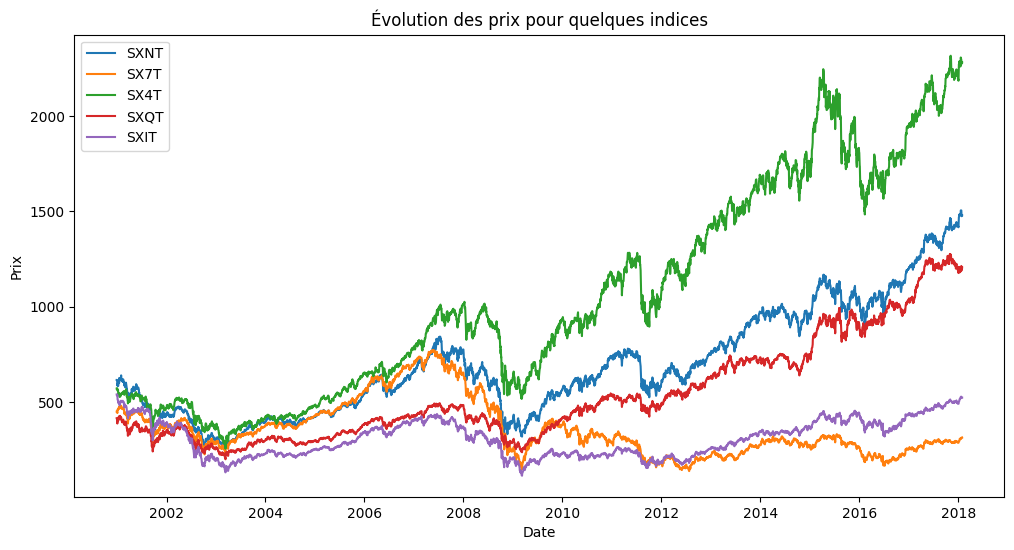


=== Analyse des rendements ===
Dimension des rendements : (4456, 19)

Premières lignes :
                SXNT      SX7T      SX4T      SXQT      SXIT      SX8T  \
Date                                                                     
2001-01-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2001-01-02 -0.018130 -0.011421  0.003665 -0.020987 -0.010288 -0.044892   
2001-01-03 -0.029103 -0.004549 -0.012948 -0.047403  0.003540 -0.050227   
2001-01-04  0.012883  0.037058 -0.008763  0.045473 -0.018963  0.083587   
2001-01-05 -0.013241  0.005628  0.006983  0.003188 -0.027701 -0.000011   

                SXAT      SXDT      SX3T      SX6T      SXKT      SXET  \
Date                                                                     
2001-01-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2001-01-02 -0.011125 -0.018902 -0.002248 -0.006420 -0.017002  0.002442   
2001-01-03  0.002921 -0.039239 -0.003889  0.010714  0.004372  0.002266   
2001-01-04  0.031331 

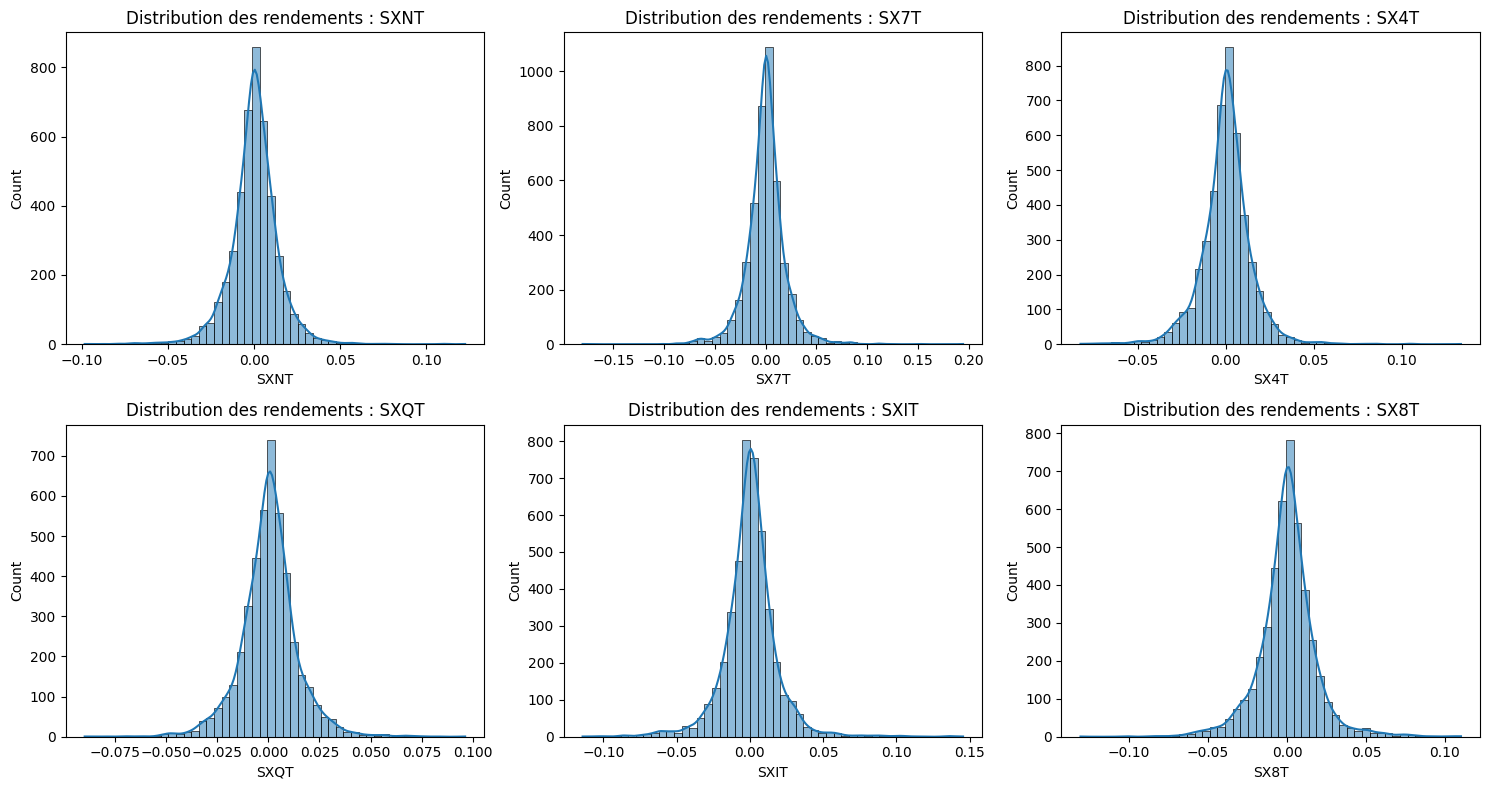

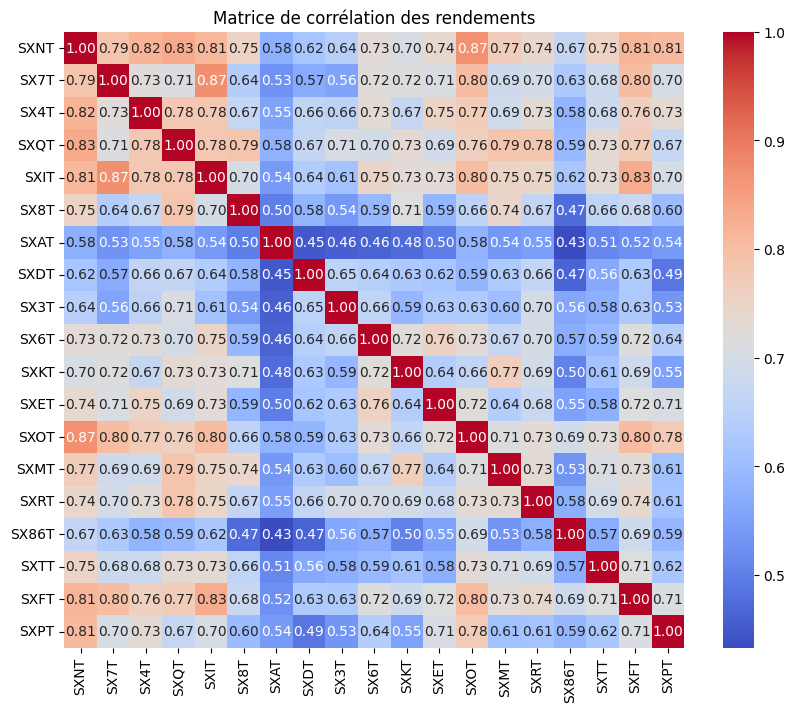

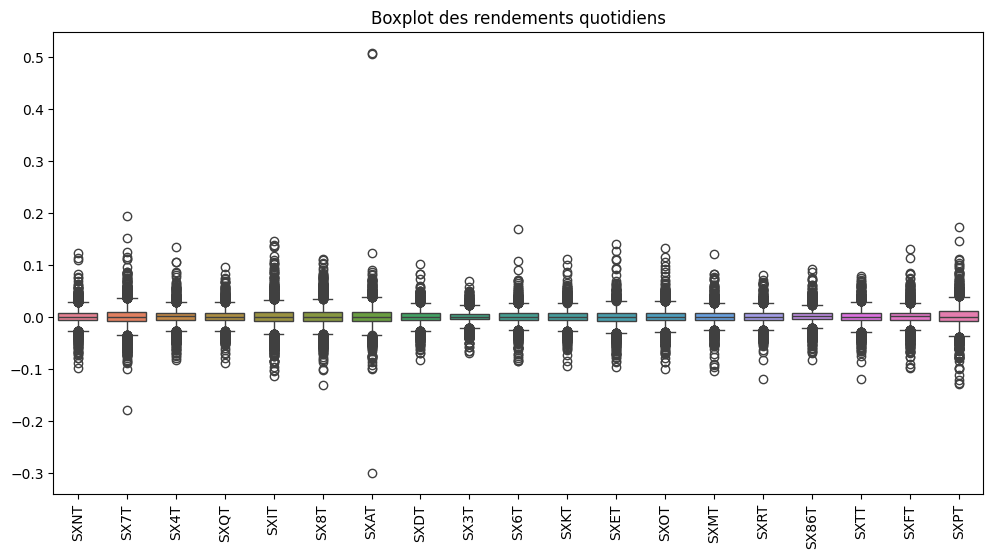


Période utilisée : 2001-01-01 à 2018-01-29


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def eda_prices(df_prices):
    """
    Réalise une EDA sur le DataFrame des prix.
    Affiche les dimensions, quelques lignes et des statistiques descriptives.
    Trace également l'évolution des prix pour quelques indices.
    """
    print("Dimension des prix :", df_prices.shape)
    print("\nPremières lignes :")
    print(df_prices.head())
    print("\nStatistiques descriptives :")
    print(df_prices.describe())

    # Visualisation de l'évolution des prix pour quelques indices (par exemple les 5 premiers)
    sample_tickers = df_prices.columns[:5]
    plt.figure(figsize=(12, 6))
    for ticker in sample_tickers:
        plt.plot(df_prices.index, df_prices[ticker], label=ticker)
    plt.title("Évolution des prix pour quelques indices")
    plt.xlabel("Date")
    plt.ylabel("Prix")
    plt.legend()
    plt.show()

def eda_returns(df_returns):
    """
    Réalise une EDA sur le DataFrame des rendements quotidiens.
    Affiche les dimensions, quelques lignes et des statistiques descriptives.
    Trace la distribution des rendements pour quelques indices, la matrice de corrélation et des boxplots.
    """
    print("Dimension des rendements :", df_returns.shape)
    print("\nPremières lignes :")
    print(df_returns.head())
    print("\nStatistiques descriptives :")
    print(df_returns.describe())

    # Vérification des valeurs manquantes
    missing = df_returns.isnull().sum()
    print("\nNombre de valeurs manquantes par ticker :")
    print(missing)

    # Histogrammes de distribution des rendements pour 6 indices (par exemple)
    sample_tickers = df_returns.columns[:6]
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))
    for i, ticker in enumerate(sample_tickers):
        ax = axs[i // 3, i % 3]
        sns.histplot(df_returns[ticker], bins=50, kde=True, ax=ax)
        ax.set_title(f"Distribution des rendements : {ticker}")
    plt.tight_layout()
    plt.show()

    # Matrice de corrélation des rendements
    plt.figure(figsize=(10, 8))
    corr = df_returns.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Matrice de corrélation des rendements")
    plt.show()

    # Boxplots pour visualiser les outliers
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df_returns)
    plt.xticks(rotation=90)
    plt.title("Boxplot des rendements quotidiens")
    plt.show()

# --- Exemple d'appel complet de l'EDA ---

# 1) Charger les prix via votre fonction existante
df_prices = load_daily_prices_multiheader('/content/Data Euro Stoxx.xlsx', sheet_name='Sheet2')

# 2) Préparer les données :
#    - Exclure le ticker de l'indice lui-même ('SXXT')
#    - Ne conserver que les dates complètes (sans valeurs manquantes)
df_prices_clean = prepare_complete_prices(df_prices, drop_tickers='SXXT')

# 3) Calculer les rendements quotidiens
df_returns = compute_daily_returns(df_prices_clean)

# 4) Réaliser l'EDA
print("=== Analyse des prix ===")
eda_prices(df_prices_clean)

print("\n=== Analyse des rendements ===")
eda_returns(df_returns)

# Affichage de la période utilisée
print("\nPériode utilisée :", df_returns.index.min().date(), "à", df_returns.index.max().date())


Aucune valeur nulle ++

La heatmap montre des corrélations entre ~0.5 et 0.8/0.9 pour la plupart des indices, ce qui est attendu pour des indices sectoriels européens.
Des corrélations élevées peuvent conduire à des portefeuilles moins diversifiés en pratique. Vous le verrez notamment lorsque vous calculerez les portefeuilles minimum variance ou ERC (ils auront tendance à attribuer des poids plus faibles aux indices les plus volatils et/ou les plus corrélés).

In [ ]:
# Calculer les rendements
df_returns = df_prices.pct_change().dropna()

# Calcul des variances quotidiennes pour chaque actif
variances = df_returns.var()
print("Variances :")
print(variances)

# Calcul du coefficient de variation (CV)
cv_variances = variances.std() / variances.mean()
print("Coefficient de variation des variances :", cv_variances)


Variances :
SXXT     0.000349
SXNT     0.000397
SX7T     0.000486
SX4T     0.000415
SXQT     0.000380
SXIT     0.000500
SX8T     0.000503
SXAT     0.000636
SXDT     0.000361
SX3T     0.000300
SX6T     0.000344
SXKT     0.000369
SXET     0.000406
SXOT     0.000240
SXMT     0.000323
SXRT     0.000327
SX86T    0.000158
SXTT     0.000363
SXFT     0.000395
SXPT     0.000530
dtype: float64
Coefficient de variation des variances : 0.2729727705990896


<ipython-input-16-d6f0b00451d9>:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_returns = df_prices.pct_change().dropna()


In [ ]:
# Calcul de la matrice de corrélation
corr_matrix = df_returns.corr()

# Extraction des corrélations hors-diagonale
corr_values = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).stack()

# Moyenne et écart-type des corrélations
mean_corr = corr_values.mean()
std_corr = corr_values.std()

print("Moyenne des corrélations :", mean_corr)
print("Écart-type des corrélations :", std_corr)


Moyenne des corrélations : 0.7491629031514193
Écart-type des corrélations : 0.14548524371991486


In [ ]:
from sklearn.decomposition import PCA

# Exécuter une ACP sur la matrice de covariance
pca = PCA()
pca.fit(df_returns)

explained_variance = pca.explained_variance_ratio_
print("Pourcentage de variance expliquée par chaque composante :")
print(explained_variance)


Pourcentage de variance expliquée par chaque composante :
[7.87755227e-01 4.32172695e-02 3.44609551e-02 2.17462130e-02
 1.80522730e-02 1.38240016e-02 1.16518093e-02 8.53985174e-03
 7.63007519e-03 7.38638411e-03 6.56186184e-03 6.23133096e-03
 6.11697504e-03 5.52729138e-03 5.14627299e-03 4.91107458e-03
 4.27654753e-03 3.76975331e-03 3.11447802e-03 8.03547651e-05]


In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize as sco

def portfolio_volatility(weights, cov_matrix):
    """
    Calcule la volatilité (écart-type) du portefeuille.

    Paramètres :
      weights    : vecteur de poids (1D numpy array)
      cov_matrix : matrice de covariance (2D numpy array)

    Retourne :
      Volatilité (float)
    """
    return np.sqrt(weights.T @ cov_matrix @ weights)

def min_variance_weights_reg(cov_matrix, reg=0):
    """
    Calcule les poids du portefeuille Minimum Variance en minimisant la variance
    (wᵀΣw) avec une régularisation sur la matrice de covariance pour améliorer
    la condition numérique.

    Paramètres :
      cov_matrix : matrice de covariance estimée (2D numpy array)
      reg        : coefficient de régularisation (ajouté à la diagonale)

    Retourne :
      Vecteur de poids (numpy array) sous contrainte long-only et somme(w)=1.
    """
    n = cov_matrix.shape[0]
    # Régularisation : ajoute un petit terme sur la diagonale pour améliorer la stabilité
    cov_matrix_reg = cov_matrix + reg * np.eye(n)

    init_guess = np.repeat(1/n, n)
    bounds = tuple((0, 1) for _ in range(n))
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    result = sco.minimize(
        fun=lambda w: np.dot(w.T, np.dot(cov_matrix_reg, w)),
        x0=init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=cons
    )

    if not result.success:
        print("Attention : L'optimisation MV n'a pas convergé :", result.message)

    return result.x

def risk_contribution(weights, cov_matrix):
    """
    Calcule la contribution au risque de chaque actif.

    Pour chaque actif i :
      RC_i = w_i * (dσ/dw_i) = w_i * [(Σw)_i] / σ(w)

    Paramètres :
      weights    : vecteur de poids (numpy array)
      cov_matrix : matrice de covariance (numpy array)

    Retourne :
      Vecteur des contributions au risque (numpy array)
    """
    sigma_p = portfolio_volatility(weights, cov_matrix)
    marginal_rc = (cov_matrix @ weights) / sigma_p  # contribution marginale
    rc = weights * marginal_rc                     # contribution totale par actif
    return rc

def erc_weights(cov_matrix):
    """
    Calcule les poids du portefeuille Equally-Weighted Risk Contribution (ERC)
    sous contrainte sum(weights)=1 et weights >= 0.

    L'objectif est de minimiser l'écart (au carré) entre les contributions
    individuelles au risque et leur moyenne.

    Paramètres :
      cov_matrix : matrice de covariance (numpy array)

    Retourne :
      Vecteur de poids ERC (numpy array)
    """
    def objective_erc(w):
        rc = risk_contribution(w, cov_matrix)
        rc_mean = np.mean(rc)
        # On souhaite que chaque RC soit égale à la moyenne
        return np.sum((rc - rc_mean)**2)

    n = cov_matrix.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = tuple((0, 1) for _ in range(n))
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    result = sco.minimize(
        fun=objective_erc,
        x0=init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=cons
    )

    if not result.success:
        print("Attention : L'optimisation ERC n'a pas convergé :", result.message)

    return result.x




La fonction ci‑dessous :

Identifie les dates de rebalancement mensuelles (dernier jour de chaque mois).

Pour chaque date de rebalancement
𝑡
t :

Récupère les 252 jours (ou le nombre de jours que vous jugez pertinent) précédant
𝑡
t pour estimer la matrice de covariance.
Calcule les poids des trois stratégies : 1/n, MV, ERC.
Conserve ces poids jusqu’à la prochaine date de rebalancement
𝑡
next
t
next
​
 .
Calcule jour par jour la performance du portefeuille sur
(
𝑡
+
1
)
(t+1) à
𝑡
next
t
next
​
 .
Construit au final un DataFrame avec la valeur cumulée (ou les rendements) pour chacun des trois portefeuilles.

In [ ]:
import calendar
from datetime import timedelta

def get_month_end_dates(dates):
    """
    À partir d'une liste d'index de dates (triées),
    renvoie la dernière date de chaque mois.
    """
    # Tri des dates au cas où
    dates_sorted = sorted(dates)

    month_ends = []
    last_month = None
    last_year = None

    for d in dates_sorted:
        year = d.year
        month = d.month

        # Quand on change de mois, la date précédente était la fin du mois
        if (month != last_month) or (year != last_year):
            # La date précédente dans la boucle est potentiellement la fin du mois
            # Mais pour être sûr d'avoir la "vraie" fin du mois, on va simplement
            # l'ajouter quand on détecte un changement de mois sur la date en cours.
            if last_month is not None:
                month_ends.append(prev_date)

        prev_date = d
        last_month = month
        last_year = year

    # Ajouter la dernière date du dataset
    if prev_date not in month_ends:
        month_ends.append(prev_date)

    return month_ends

def backtest_strategies_monthly(df_prices, window=252):
    """
    Backtest mensuel (logique de l'article) :
    - Rebalancement le dernier jour de chaque mois
    - Estimation de la matrice de covariance sur 'window' jours précédents
    - Construction de 3 portefeuilles : 1/n, MV, ERC
    - Calcul de la performance quotidienne hors échantillon

    Paramètres :
    -----------
    df_prices : DataFrame de prix quotidiens, index=Date, columns=Tickers
    window    : nombre de jours (business days) pour l'estimation rolling

    Retour :
    --------
    df_portvals : DataFrame contenant la valeur cumulée quotidienne de chaque portefeuille
    df_weights  : dictionnaire ou DataFrame avec les poids alloués à chaque date de rebalancement
    """
    # 1) Calculer les rendements quotidiens
    df_returns = df_prices.pct_change().dropna()

    # 2) Identifier les dates de rebalancement (fin de mois)
    all_dates = df_returns.index
    month_ends = get_month_end_dates(all_dates)

    tickers = df_returns.columns
    n = len(tickers)

    # Pour stocker la valeur cumulée des portefeuilles (base = 1)
    df_portvals = pd.DataFrame(index=df_returns.index,
                               columns=['EW', 'MV', 'ERC'],
                               data=1.0)

    # Pour mémoriser les poids alloués chaque mois
    list_allocs = []

    # 3) Boucle sur chaque date de rebalancement
    for i in range(1, len(month_ends)):
        rebalance_date = month_ends[i]
        prev_rebalance_date = month_ends[i-1]

        # Fenêtre d'estimation = [rebalance_date - window, rebalance_date)
        # On récupère les rendements quotidiens sur window jours avant la date de rebalancement
        # (exclure le jour de rebalancement lui-même si on veut strictement hors échantillon)

        window_start = df_returns.index.get_loc(rebalance_date) - window
        if window_start < 0:
            # Pas assez d'historique pour ce rebalancement => on skip
            continue

        # Dates effectives pour la fenêtre d'estimation
        estimation_start_date = df_returns.index[window_start]
        estimation_end_date = df_returns.index[df_returns.index.get_loc(rebalance_date) - 1]

        # Récupérer la sous-période de rendements
        df_estimation = df_returns.loc[estimation_start_date:estimation_end_date]

        # Calcul de la matrice de covariance
        cov_matrix = df_estimation.cov().values

        # 3.1) Poids 1/n
        w_ew = np.repeat(1/n, n)

        # 3.2) Poids Minimum Variance
        w_mv = min_variance_weights_reg(cov_matrix)

        # 3.3) Poids ERC
        w_erc = erc_weights(cov_matrix)

        # On stocke dans une structure
        weights_dict = {
            'Date': rebalance_date,
            'EW': w_ew,
            'MV': w_mv,
            'ERC': w_erc
        }
        list_allocs.append(weights_dict)

        # 4) Calcul de la performance quotidienne du portefeuille jusqu'au prochain rebalancement
        # next_rebalance_date = month_ends[i+1] si on veut s'arrêter la veille du prochain
        if i == len(month_ends) - 1:
            # Dernière fenêtre => on va jusqu'à la fin
            next_rebalance_date = df_returns.index[-1]
        else:
            next_rebalance_date = month_ends[i+1]

        # Récupérer les dates de trading entre (rebalance_date+1) et next_rebalance_date (inclus)
        # Si rebalance_date == next_rebalance_date, la période est vide.
        sub_period = df_returns.loc[rebalance_date:next_rebalance_date]
        # (On pourrait décaler d'un jour si on veut rebalancer en "close" du rebalance_date
        #  et appliquer dès le lendemain. Tout dépend de la convention de l’article.)

        for date in sub_period.index:
            # Rendement vectoriel ce jour
            r_vec = df_returns.loc[date].values  # shape (n, )
            # Calcul du rendement du portefeuille
            ret_ew = np.dot(w_ew, r_vec)
            ret_mv = np.dot(w_mv, r_vec)
            ret_erc = np.dot(w_erc, r_vec)

            # On met à jour la valeur cumulée
            df_portvals.loc[date, 'EW'] *= (1.0 + ret_ew)
            df_portvals.loc[date, 'MV'] *= (1.0 + ret_mv)
            df_portvals.loc[date, 'ERC']*= (1.0 + ret_erc)

    # Nettoyage final : retirer la partie avant le premier rebalancement effectif
    # (c'est-à-dire avant la toute première date où on a pu calculer des poids)
    if len(list_allocs) > 0:
        first_valid_date = list_allocs[0]['Date']
        df_portvals = df_portvals.loc[df_portvals.index >= first_valid_date]

    # Mise en forme des poids en DataFrame
    # On aura un MultiIndex (Date, Stratégie) x Ticker
    df_weights_list = []
    for d in list_allocs:
        date_ = d['Date']
        for strat in ['EW','MV','ERC']:
            row = pd.DataFrame({
                'Date': [date_],
                'Strategy': [strat]
            })
            # Ajouter colonnes de poids
            row = pd.concat([row,
                             pd.DataFrame(d[strat].reshape(1,-1),
                                          columns=tickers)],
                            axis=1)
            df_weights_list.append(row)
    df_weights = pd.concat(df_weights_list, ignore_index=True)

    return df_portvals, df_weights


In [ ]:
# Supposons que vous avez déjà préparé df_prices_clean (sans SXXT, etc.)
# comme dans vos étapes précédentes

df_portvals, df_weights = backtest_strategies_monthly(df_prices_clean, window=252)

# Afficher un aperçu
print("Valeurs cumulées des portefeuilles :")
print(df_portvals.head(10))

print("\nPoids alloués lors des rebalancements :")
print(df_weights.head(10))

# Exemple : calcul de performances finales
final_values = df_portvals.iloc[-1]
perf = (final_values - 1) * 100
print("\nPerformance cumulée sur la période :")
print(perf)

# Exemple : calcul de la volatilité annualisée (approximative)
df_rets_port = df_portvals.pct_change().dropna()
annualized_vol = df_rets_port.std() * np.sqrt(252) * 100
print("\nVolatilité annualisée (approx) :")
print(annualized_vol)


Valeurs cumulées des portefeuilles :
                  EW        MV       ERC
Date                                    
2001-12-31  1.000000  1.000000  1.000000
2002-01-01  1.000000  1.000000  1.000000
2002-01-02  0.992920  0.992920  0.992920
2002-01-03  1.016189  1.016189  1.016189
2002-01-04  1.001027  1.001027  1.001027
2002-01-07  0.991041  0.991041  0.991041
2002-01-08  0.994032  0.994032  0.994032
2002-01-09  1.002327  1.002327  1.002327
2002-01-10  0.988533  0.988533  0.988533
2002-01-11  1.005584  1.005584  1.005584

Poids alloués lors des rebalancements :
        Date Strategy      SXNT      SX7T      SX4T      SXQT      SXIT  \
0 2001-12-31       EW  0.052632  0.052632  0.052632  0.052632  0.052632   
1 2001-12-31       MV  0.052632  0.052632  0.052632  0.052632  0.052632   
2 2001-12-31      ERC  0.052632  0.052632  0.052632  0.052632  0.052632   
3 2002-01-31       EW  0.052632  0.052632  0.052632  0.052632  0.052632   
4 2002-01-31       MV  0.052632  0.052632  0.052632  0.

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import pandas as pd

def select_representative_indices(df_returns, n_clusters=7, threshold=None):
    """
    Sélectionne un indice représentatif par cluster en utilisant un clustering hiérarchique.
    Vous pouvez soit spécifier un nombre fixe de clusters (n_clusters) soit un seuil de distance (threshold).

    Paramètres :
      df_returns : DataFrame des rendements (colonnes = tickers)
      n_clusters : nombre de clusters souhaité (par défaut 3)
      threshold  : seuil de distance pour former les clusters (optionnel)

    Retourne :
      Liste d'indices représentatifs.
    """
    # Calcul de la distance entre les indices à partir de la corrélation (distance = 1 - corrélation)
    dist_array = pdist(df_returns.T, metric='correlation')
    Z = linkage(dist_array, method='average')

    # Formation des clusters : on utilise n_clusters si spécifié, sinon le seuil
    if n_clusters is not None:
        cluster_labels = fcluster(Z, t=n_clusters, criterion='maxclust')
    elif threshold is not None:
        cluster_labels = fcluster(Z, t=threshold, criterion='distance')
    else:
        raise ValueError("Veuillez spécifier n_clusters ou threshold.")

    # Créer un DataFrame associant chaque ticker à son cluster
    clusters_df = pd.DataFrame({'Ticker': df_returns.columns, 'Cluster': cluster_labels})

    representatives = []
    # Pour chaque cluster, on choisit l'indice avec la corrélation moyenne la plus faible (i.e. le moins redondant)
    for cluster in clusters_df['Cluster'].unique():
        tickers_in_cluster = clusters_df[clusters_df['Cluster'] == cluster]['Ticker']
        sub_corr = df_returns[tickers_in_cluster].corr()
        avg_corr = sub_corr.mean()
        rep = avg_corr.idxmin()  # indice avec la corrélation moyenne minimale
        representatives.append(rep)
    return representatives

# Exemple d'utilisation :
selected_indices = select_representative_indices(df_returns, n_clusters=3)
print("Indices sélectionnés (moins corrélés) :", selected_indices)



Indices sélectionnés (moins corrélés) : ['SXDT', 'SXAT', 'SX86T']


In [ ]:
# Création du sous-portfolio à partir des indices sélectionnés
df_prices_sub = df_prices_clean[selected_indices]

# Lancer le backtest sur ce sous-portfolio
df_portvals_sub, df_weights_sub = backtest_strategies_monthly(df_prices_sub, window=252)

# Affichage des résultats
print("Valeurs cumulées des portefeuilles (sous-portfolio) :")
print(df_portvals_sub.head(10))

print("\nPoids alloués lors des rebalancements (sous-portfolio) :")
print(df_weights_sub.head(10))

final_values_sub = df_portvals_sub.iloc[-1]
perf_sub = (final_values_sub - 1) * 100
print("\nPerformance cumulée sur la période (sous-portfolio) :")
print(perf_sub)

df_rets_port_sub = df_portvals_sub.pct_change().dropna()
annualized_vol_sub = df_rets_port_sub.std() * np.sqrt(252) * 100
print("\nVolatilité annualisée (approx) (sous-portfolio) :")
print(annualized_vol_sub)


Valeurs cumulées des portefeuilles (sous-portfolio) :
                  EW        MV       ERC
Date                                    
2001-12-31  1.000000  1.000000  1.000000
2002-01-01  1.000000  1.000000  1.000000
2002-01-02  0.993439  0.993439  0.993439
2002-01-03  1.006705  1.006705  1.006705
2002-01-04  1.002754  1.002754  1.002754
2002-01-07  0.988934  0.988934  0.988934
2002-01-08  0.998709  0.998709  0.998709
2002-01-09  1.004523  1.004523  1.004523
2002-01-10  0.991567  0.991567  0.991567
2002-01-11  1.005198  1.005198  1.005198

Poids alloués lors des rebalancements (sous-portfolio) :
        Date Strategy      SXDT      SXAT     SX86T
0 2001-12-31       EW  0.333333  0.333333  0.333333
1 2001-12-31       MV  0.333333  0.333333  0.333333
2 2001-12-31      ERC  0.333333  0.333333  0.333333
3 2002-01-31       EW  0.333333  0.333333  0.333333
4 2002-01-31       MV  0.333333  0.333333  0.333333
5 2002-01-31      ERC  0.333333  0.333333  0.333333
6 2002-02-28       EW  0.333333 

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import scipy.optimize as sco

# ------------------------------------------------
# 1. Définition des fonctions d'optimisation
# ------------------------------------------------

def portfolio_volatility(weights, cov_matrix):
    """Calcule l'écart-type du portefeuille."""
    return np.sqrt(weights.T @ cov_matrix @ weights)

def min_variance_weights_reg(cov_matrix, reg=0):
    """Calcule les poids du portefeuille minimum variance (long-only)."""
    n = cov_matrix.shape[0]
    cov_matrix_reg = cov_matrix + reg * np.eye(n)
    init_guess = np.repeat(1/n, n)
    bounds = tuple((0, 1) for _ in range(n))
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    result = sco.minimize(
        fun=lambda w: np.dot(w.T, np.dot(cov_matrix_reg, w)),
        x0=init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=cons
    )
    if not result.success:
        print("Attention : optimisation MV non convergente :", result.message)
    return result.x

def risk_contribution(weights, cov_matrix):
    """Calcule la contribution au risque de chaque actif."""
    sigma_p = portfolio_volatility(weights, cov_matrix)
    marginal_rc = (cov_matrix @ weights) / sigma_p
    return weights * marginal_rc

def erc_weights(cov_matrix):
    """Calcule les poids du portefeuille ERC (Equal Risk Contribution)."""
    def objective_erc(w):
        rc = risk_contribution(w, cov_matrix)
        rc_mean = np.mean(rc)
        return np.sum((rc - rc_mean)**2)

    n = cov_matrix.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = tuple((0, 1) for _ in range(n))
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    result = sco.minimize(
        fun=objective_erc,
        x0=init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=cons
    )
    if not result.success:
        print("Attention : optimisation ERC non convergente :", result.message)
    return result.x

# ------------------------------------------------
# 2. Backtest mensuel des stratégies
# ------------------------------------------------

def backtest_strategies_monthly(df_prices, window=252):
    """
    Backtest mensuel :
      - Rebalancement le dernier jour de trading de chaque mois
      - Estimation de la covariance sur 'window' jours précédents
      - Trois portefeuilles : EW, MV, ERC
      - Calcul de la performance quotidienne hors échantillon
    Retourne :
      - df_portvals : valeurs cumulées quotidiennes
      - df_weights  : poids alloués à chaque rebalancement
    """
    # Calcul des rendements quotidiens
    df_returns = df_prices.pct_change(fill_method=None).dropna()

    # Récupérer le dernier jour de trading effectif de chaque mois
    month_ends = df_returns.index.to_series().groupby(df_returns.index.to_period('M')).max().values

    tickers = df_returns.columns
    n = len(tickers)

    # Initialiser les portefeuilles (valeur de départ = 1)
    df_portvals = pd.DataFrame(index=df_returns.index, columns=['EW', 'MV', 'ERC'], data=1.0)
    list_allocs = []

    # Boucle sur chaque rebalancement (à partir du deuxième mois)
    for i in range(1, len(month_ends)):
        rebalance_date = month_ends[i]
        # Déterminer la fenêtre d'estimation sur 'window' jours (hors jour de rebalancement)
        window_end_loc = df_returns.index.get_loc(rebalance_date) - 1
        window_start_loc = window_end_loc - window + 1
        if window_start_loc < 0:
            continue  # pas assez d'historique

        estimation_start_date = df_returns.index[window_start_loc]
        estimation_end_date = df_returns.index[window_end_loc]
        df_estimation = df_returns.loc[estimation_start_date:estimation_end_date]
        cov_matrix = df_estimation.cov().values

        # Calcul des trois stratégies
        w_ew = np.repeat(1/n, n)
        w_mv = min_variance_weights_reg(cov_matrix)
        w_erc = erc_weights(cov_matrix)

        weights_dict = {'Date': rebalance_date, 'EW': w_ew, 'MV': w_mv, 'ERC': w_erc}
        list_allocs.append(weights_dict)

        # Définir la période jusqu'au prochain rebalancement
        if i == len(month_ends) - 1:
            next_rebalance_date = df_returns.index[-1]
        else:
            next_rebalance_date = month_ends[i+1]

        sub_period = df_returns.loc[rebalance_date:next_rebalance_date]
        for date in sub_period.index:
            r_vec = df_returns.loc[date].values
            df_portvals.loc[date, 'EW'] *= (1 + np.dot(w_ew, r_vec))
            df_portvals.loc[date, 'MV'] *= (1 + np.dot(w_mv, r_vec))
            df_portvals.loc[date, 'ERC'] *= (1 + np.dot(w_erc, r_vec))

    if list_allocs:
        first_valid_date = list_allocs[0]['Date']
        df_portvals = df_portvals.loc[df_portvals.index >= first_valid_date]

    # Organisation des poids sous forme de DataFrame
    df_weights_list = []
    for alloc in list_allocs:
        date_ = alloc['Date']
        for strat in ['EW', 'MV', 'ERC']:
            row = pd.DataFrame({'Date': [date_], 'Strategy': [strat]})
            row = pd.concat([row, pd.DataFrame(alloc[strat].reshape(1, -1), columns=tickers)], axis=1)
            df_weights_list.append(row)
    df_weights = pd.concat(df_weights_list, ignore_index=True)

    return df_portvals, df_weights

# ------------------------------------------------
# 3. Extraction des données depuis Yahoo Finance
# ------------------------------------------------

# Choix d'actifs supposés faiblement corrélés (actifs de classes différentes)
tickers = ["GC=F", "CL=F", "TLT", "^VIX", "BTC-USD"]
start_date = "2015-01-01"
end_date   = "2016-12-31"

data = yf.download(tickers, start=start_date, end=end_date, interval="1d", auto_adjust=True)

# On récupère les prix ajustés (ou Close en cas d'absence d'Adj Close)
if 'Adj Close' in data:
    df_prices = data['Adj Close']
else:
    df_prices = data['Close']

# Pour éviter le warning, on réaffecte le résultat de dropna()
df_prices = df_prices.dropna()

print("Premiers prix récupérés :")
print(df_prices.head())

# ------------------------------------------------
# 4. Exécution du backtest
# ------------------------------------------------

portvals, weights = backtest_strategies_monthly(df_prices, window=252)

print("\nValeurs cumulées des portefeuilles :")
print(portvals.tail())

print("\nPoids alloués lors des derniers rebalancements :")
print(weights.tail())


[*********************100%***********************]  5 of 5 completed


Premiers prix récupérés :
Ticker         BTC-USD       CL=F         GC=F         TLT       ^VIX
Date                                                                 
2015-01-02  315.032013  52.689999  1186.000000   98.316475  17.790001
2015-01-05  274.473999  50.040001  1203.900024   99.860893  19.920000
2015-01-06  286.188995  47.930000  1219.300049  101.660126  21.120001
2015-01-07  294.337006  48.650002  1210.599976  101.459335  19.309999
2015-01-08  283.348999  48.790001  1208.400024  100.115723  17.010000

Valeurs cumulées des portefeuilles :
                  EW        MV       ERC
Date                                    
2016-12-23  1.014685  1.015440  1.017253
2016-12-27  1.015678  1.008213  1.010604
2016-12-28  1.027594  1.014177  1.019215
2016-12-29  1.008610  1.003321  1.004542
2016-12-30  1.013070  0.994237  0.998834

Poids alloués lors des derniers rebalancements :
         Date Strategy   BTC-USD      CL=F      GC=F       TLT      ^VIX
31 2016-11-30       MV  0.208614  0.

In [ ]:
# Calcul des rendements quotidiens des portefeuilles
port_returns = portvals.pct_change().dropna()

# Calcul de la volatilité annualisée pour chaque stratégie
annualized_volatility = port_returns.std() * np.sqrt(252)

# Calcul du rendement annualisé
# On considère que la période totale est la durée entre la première et la dernière date
nb_jours = (portvals.index[-1] - portvals.index[0]).days
annees = nb_jours / 365.25
annualized_return = (portvals.iloc[-1] / portvals.iloc[0]) ** (1 / annees) - 1

# Affichage des résultats
print("Rendements annualisés :")
print(annualized_return)
print("\nVolatilité annualisée :")
print(annualized_volatility)

Rendements annualisés :
EW     0.032139
MV    -0.009314
ERC    0.001706
dtype: float64

Volatilité annualisée :
EW     0.427723
MV     0.257873
ERC    0.288312
dtype: float64


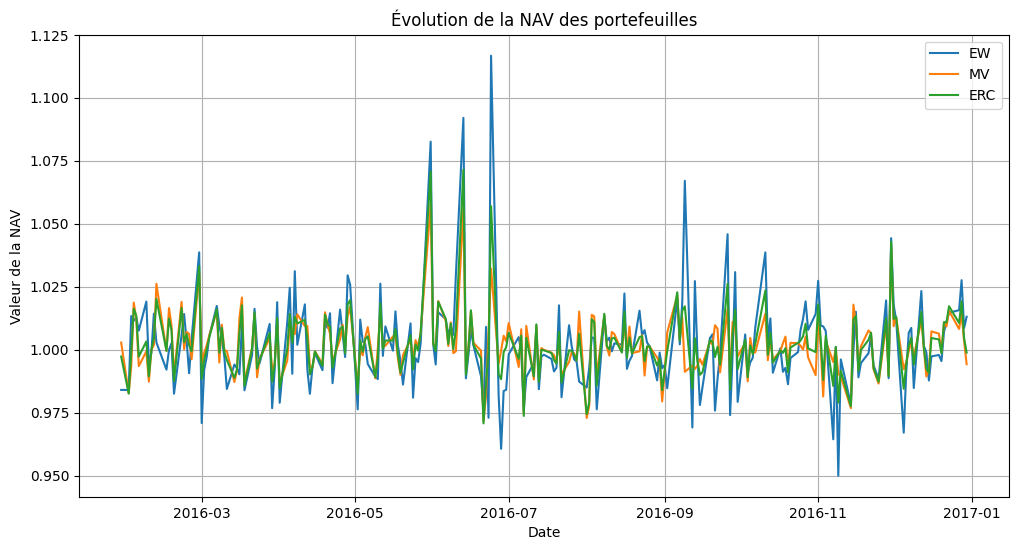

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tracé des courbes NAV (performance cumulée des portefeuilles)
plt.figure(figsize=(12, 6))
for col in portvals.columns:
    plt.plot(portvals.index, portvals[col], label=col)

plt.xlabel("Date")
plt.ylabel("Valeur de la NAV")
plt.title("Évolution de la NAV des portefeuilles")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
def compute_risk_contribution(weights, cov_matrix):
    """
    Calcule la contribution au risque de chaque actif dans un portefeuille.

    Paramètres :
    - weights : np.array, vecteur des poids du portefeuille
    - cov_matrix : np.array, matrice de covariance des actifs

    Retourne :
    - rc : np.array, vecteur des contributions au risque de chaque actif
    """
    portfolio_volatility = np.sqrt(weights.T @ cov_matrix @ weights)  # σ_p
    marginal_contrib = cov_matrix @ weights / portfolio_volatility     # (Σw) / σ_p
    rc = weights * marginal_contrib                                    # RC_i = w_i * marginal_contrib
    return rc


In [ ]:
def optimize_erc_weights(cov_matrix):
    """
    Calcule les poids du portefeuille Equally Weighted Risk Contribution (ERC)
    en assurant une égalité entre les contributions au risque.

    Paramètres :
    - cov_matrix : np.array, matrice de covariance des actifs

    Retourne :
    - np.array, vecteur des poids optimisés
    """

    def objective_erc(w):
        """Minimise l'écart quadratique entre les contributions au risque et leur moyenne."""
        rc = compute_risk_contribution(w, cov_matrix)
        rc_mean = np.mean(rc)
        return np.sum((rc - rc_mean)**2)  # Objectif ERC

    # Initialisation : répartition uniforme
    n = cov_matrix.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = tuple((0, 1) for _ in range(n))  # Contraintes long-only
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Somme des poids = 1

    # Optimisation
    result = sco.minimize(
        fun=objective_erc,
        x0=init_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=cons
    )

    if not result.success:
        print("⚠️ Attention : l'optimisation ERC n'a pas convergé :", result.message)

    return result.x


In [ ]:
# Comparer les contributions au risque des actifs après optimisation ERC
erc_weights = optimize_erc_weights(cov_matrix)
erc_risk_contribs = compute_risk_contribution(erc_weights, cov_matrix)

# Affichage des résultats
df_risk_contributions = pd.DataFrame({
    "Actif": df_prices.columns,
    "Poids ERC": erc_weights,
    "Contribution au risque ERC": erc_risk_contribs
})

print("\nContributions au risque du portefeuille ERC :")
print(df_risk_contributions)



Contributions au risque du portefeuille ERC :
     Actif  Poids ERC  Contribution au risque ERC
0  BTC-USD   0.237832                    0.006188
1     CL=F   0.236452                    0.002316
2     GC=F   0.222983                    0.000733
3      TLT   0.220811                    0.000384
4     ^VIX   0.081922                    0.003298


In [ ]:
"""
sdpd_demo.py
============

• Stochastic-Proportional-Dividend (SDPD) model
  – arbitrary amplitude vector  E_i  (set Ei = 1 for “normal” noise,
    Ei = D_i for log-normal yield noise, or any blend)
  – compensation constants C_i built with the quadratic recursion
    of Appendix A.2 (c₁, c_i(p) formula)
  – equity-vol bootstrap σ_k reproducing ATM term structure
  – coupled OU/GBM simulation with in-step correlation ρ_k
  – Monte-Carlo pricing of dividend swaps (or any OOD payoff)

• Quick diffusion check:
  compares an ATM Black–Scholes call (analytic) with the SDPD
  Monte-Carlo price for several maturities.
"""

# ------------------------------------------------------------
# 0 · imports & containers
# ------------------------------------------------------------
import numpy as np
from numpy.random import default_rng
from scipy.optimize import minimize
from scipy.stats import norm
from dataclasses import dataclass, field

# ---------- data classes ------------------------------------
@dataclass
class MarketData:
    T:         np.ndarray     # ATM maturities  T_k
    sigma_atm: np.ndarray     # market ATM vols Σ_impl(T_k)
    forwards:  np.ndarray     # forward curve (unused in this demo)
    tau:       np.ndarray     # dividend dates  τ_i
    D:         np.ndarray     # deterministic log-ratios  D_i
    ood_mat:   np.ndarray     # OOD maturities
    ood_price: np.ndarray     # OOD market prices
    w_ood:     np.ndarray     # OOD weights
    r:  float;  mu: float;  S0: float;  y0: float


@dataclass
class ModelParams:
    kappa: float; nu: float; rho: float
    Ei:    np.ndarray                   # amplitude vector  E_i
    C:     np.ndarray = field(init=False)
    sigma_k: np.ndarray = field(init=False)


# ------------------------------------------------------------
# 1 · deterministic building blocks
# ------------------------------------------------------------
def Gamma(t, kappa, nu):
    """Γ(t,0)  (vectorised t)"""
    return 0.5 * nu**2 * (1.0 - np.exp(-2*kappa*t)) / kappa


def Theta_vec(tau, kappa, rho, nu, sigma_piece, T_grid):
    """
    Θ(tau,0) = ρν ∫₀^τ e^{−κ(τ-s)} σ(s) ds
    where σ is piecewise-constant: sigma_piece[k] on (T_{k-1},T_k].
    """
    integ, left = 0.0, 0.0
    for σ, right in zip(sigma_piece, T_grid):
        seg_end = min(tau, right)
        if seg_end <= left:
            break
        integ += σ * (np.exp(-kappa*(tau-seg_end))
                      - np.exp(-kappa*(tau-left))) / kappa
        if seg_end == tau:
            break
        left = right
    return rho * nu * integ


# ------------------------------------------------------------
# 2 · compensation constants  —  quadratic recursion
# ------------------------------------------------------------
def build_C_recursive(md: MarketData, mp: ModelParams):
    """
    Implements Appendix A.2 recursion:
      c₁(p)  and  c_i(p)=… + c_{i-1}((E_i+p)K_i)
    Each c_i is quadratic → propagate coefficients (a,b,c).
    Finally  C_i = D_i – a_i  (since a_i = c_i(0)).
    """
    τ, κ, ν, ρ = md.tau, mp.kappa, mp.nu, mp.rho
    E          = mp.Ei
    Γ          = Gamma(τ, κ, ν)

    # Θ_i needs σ_k; if absent (first pass) set to zero
    if hasattr(mp, "sigma_k"):
        Θ = np.array([Theta_vec(ti, κ, ρ, ν, mp.sigma_k, md.T)
                      for ti in τ])
    else:
        Θ = np.zeros_like(τ)

    a = b = c = 0.0            # coefficients of c_{i-1}(p)
    C_out = np.zeros_like(τ)
    for i, ti in enumerate(τ):
        Ei = E[i];  Γi = Γ[i];  Θi = Θ[i]
        if i == 0:
            # c₁(p) quadratic coefficients
            a = -Ei*Θi + Γi*Ei**2
            b = -Θi   + 2*Γi*Ei
            c =  Γi
        else:
            Ki = np.exp(-κ*(ti - τ[i-1]))
            a = (-Ei*Θi + Γi*Ei**2
                 + a + b*Ki*Ei + c*(Ki*Ei)**2)
            b = (-Θi + 2*Γi*Ei
                 + b*Ki + 2*c*Ki**2*Ei)
            c =  Γi + c*Ki**2
        C_out[i] = md.D[i] - a          # C_i
    mp.C = C_out


# ------------------------------------------------------------
# 3 · σ-bootstrap (quadratic eq. (6))
# ------------------------------------------------------------
def bootstrap_sigma(md: MarketData, mp: ModelParams):
    κ, ν, ρ = mp.kappa, mp.nu, mp.rho
    τ, T, E = md.tau, md.T, mp.Ei
    Γ = Gamma(τ, κ, ν)

    Xi = np.cumsum(np.concatenate(([E[0]*Γ[0]],
                                   2*E[1:]*Γ[1:])))

    N = len(T); σ = np.zeros(N)
    ΔT = np.diff(np.concatenate(([0.0], T)))
    K_r = (np.exp(κ*T) - np.exp(κ*np.concatenate(([0.0], T[:-1])))) / κ

    for k in range(N):
        lo = T[k-1] if k else 0.0
        mask = (τ > lo) & (τ <= T[k])
        if not np.any(mask):
            σ[k] = md.sigma_atm[k];  continue

        Oik = (np.exp(κ*τ[mask]) - np.exp(κ*lo)) / κ
        Bk  = -2 * ρ * ν * np.sum(E[mask] * Oik)
        Cdiv = np.sum(
            E[mask] * (Xi[mask]*np.exp(-κ*(T[k]-τ[mask]))
                        - 2*ρ*ν*np.exp(-κ*τ[mask])
                          * np.dot(σ[:k], K_r[:k] if k else np.zeros(0)))
        )
        Ccoeff = (T[k]*md.sigma_atm[k]**2
                  - (T[k-1]*md.sigma_atm[k-1]**2 if k else 0.0)
                  - Cdiv)
        disc = Bk**2 + 4*ΔT[k]*Ccoeff
        σ[k] = (-Bk + np.sqrt(max(disc, 0.0))) / (2*ΔT[k])

    mp.sigma_k = σ


# ------------------------------------------------------------
# 4 · one-step OU/GBM kernel
# ------------------------------------------------------------
def OU_GBM_step(y, S, dt, σ, κ, ν, ρ, r, μ, rng):
    var_y = ν**2 * (1 - np.exp(-2*κ*dt)) / (2*κ)
    ρk = ρ * (1 - np.exp(-κ*dt)) \
              / np.sqrt((1 - np.exp(-2*κ*dt))*2*κ*dt)
    Z1, Z2 = rng.standard_normal(2)
    y_n = y*np.exp(-κ*dt) + np.sqrt(var_y)*(ρk*Z1 + np.sqrt(1-ρk**2)*Z2)
    S_n = S*np.exp((r-μ-0.5*σ**2)*dt + σ*np.sqrt(dt)*Z1)
    return y_n, S_n


# ------------------------------------------------------------
# 5 · Monte-Carlo price of a dividend-swap OOD
# ------------------------------------------------------------
def price_OOD(md: MarketData, mp: ModelParams,
              n_paths=40_000, dt=1/252):
    rng = default_rng(42)
    steps = int(np.ceil(md.ood_mat[-1] / dt))
    grid  = np.linspace(0.0, steps*dt, steps+1)

    # σ daily
    σ_daily = np.zeros_like(grid)
    atm_idx = np.searchsorted(grid, md.T)
    for k,(i0,i1) in enumerate(zip(np.concatenate(([0],atm_idx[:-1])),atm_idx)):
        σ_daily[i0:i1] = mp.sigma_k[k]
    σ_daily[atm_idx[-1]:] = mp.sigma_k[-1]

    pay = np.zeros(len(md.ood_mat))
    for _ in range(n_paths):
        S, y = md.S0, md.y0
        acc  = np.zeros(len(md.ood_mat))
        dptr = optr = 0
        for j, t in enumerate(grid[:-1]):
            if dptr < len(md.tau) and np.isclose(t, md.tau[dptr], atol=dt/2):
                d_i = md.D[dptr] + mp.Ei[dptr]*y + mp.C[dptr]
                cash = S * (1 - np.exp(-d_i))
                S   *= np.exp(-d_i)
                acc[optr:] += cash
                dptr += 1
            if optr < len(md.ood_mat) and np.isclose(t, md.ood_mat[optr], atol=dt/2):
                pay[optr] += max(acc[optr], 0.0)
                optr += 1
                if optr == len(md.ood_mat):
                    break
            y, S = OU_GBM_step(y, S, dt, σ_daily[j],
                               mp.kappa, mp.nu, mp.rho,
                               md.r, md.mu, rng)
    return pay/n_paths * np.exp(-md.r * md.ood_mat)


# ------------------------------------------------------------
# 6 · objective and calibration (κ,ν,ρ only)
# ------------------------------------------------------------
def objective(theta, md, Ei):
    κ,ν,ρ = theta
    mp = ModelParams(κ,ν,ρ,Ei)
    build_C_recursive(md, mp)     # Θ=0 first
    bootstrap_sigma(md, mp)
    build_C_recursive(md, mp)     # Θ uses σ_k
    model = price_OOD(md, mp)
    return np.sum(md.w_ood*(model-md.ood_price)**2), mp, model


def calibrate(md, Ei):
    x0 = np.array([1.0,0.25,-0.5])
    bnds=[(0.05,4.0),(0.05,1.5),(-0.99,0.99)]
    res = minimize(lambda x: objective(x,md,Ei)[0],
                   x0, bounds=bnds, method='L-BFGS-B',
                   options={'ftol':1e-8,'disp':True})
    loss, mp, prices = objective(res.x, md, Ei)
    print("MC OOD prices =", prices.round(4))
    return mp, loss


# ------------------------------------------------------------
# 7 · Black–Scholes analytic call price (ATM)
# ------------------------------------------------------------
def bs_call(S0, K, r, sigma, T):
    if T == 0.0:
        return max(S0-K, 0.0)
    d1 = (np.log(S0/K) + 0.5*sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def mc_call_SDPD(md, mp, T, n_paths=150_000, dt=1/252):
    rng = default_rng(2024)
    steps = int(np.ceil(T/dt))
    grid  = np.linspace(0.0, steps*dt, steps+1)
    # build σ(t)
    σ_daily = np.zeros_like(grid)
    atm_idx = np.searchsorted(grid, md.T)
    for k,(i0,i1) in enumerate(zip(np.concatenate(([0],atm_idx[:-1])),atm_idx)):
        σ_daily[i0:i1] = mp.sigma_k[k]
    σ_daily[atm_idx[-1]:] = mp.sigma_k[-1]

    payoff = 0.0
    for _ in range(n_paths):
        S, y = md.S0, md.y0
        dptr = 0
        for j,t in enumerate(grid[:-1]):
            if dptr < len(md.tau) and np.isclose(t, md.tau[dptr], atol=dt/2):
                di = md.D[dptr] + mp.Ei[dptr]*y + mp.C[dptr]
                S *= np.exp(-di);  dptr += 1
            y, S = OU_GBM_step(y,S,dt,σ_daily[j],
                               mp.kappa, mp.nu, mp.rho,
                               md.r, md.mu, rng)
        payoff += max(S-md.S0, 0.0)        # ATM strike K=S0
    return payoff/n_paths * np.exp(-md.r*T)


# ------------------------------------------------------------
# 8 · demo / test harness
# ------------------------------------------------------------
if __name__ == "__main__":

    # --------- mock market data -------------------------------------------
    md = MarketData(
        T=np.array([0.5,1.0,2.0,3.0]),
        sigma_atm=np.array([0.25,0.26,0.27,0.28]),
        forwards=np.array([105,108,115,120]),
        tau=np.array([0.5,1.5,2.5,3.0]),
        D=np.array([0.04,0.10,0.18,0.25]),
        ood_mat=np.array([1.0,2.0,3.0]),
        ood_price=np.array([2.2,3.0,4.2]),
        w_ood=np.ones(3),
        r=0.02, mu=0.0, S0=100.0, y0=0.0
    )

    # choose amplitude regime
    Ei = np.ones_like(md.tau)       # normal noise
    # Ei = md.D.copy()             # log-normal noise
    # Ei = 0.7 + 0.3*md.D          # mixed

    # ------- calibrate κ,ν,ρ on pseudo-OOD -------------------------------
    mp, loss = calibrate(md, Ei)
    print("\nCalibrated κ,ν,ρ =", mp.kappa, mp.nu, mp.rho)
    print("σ_k =", mp.sigma_k.round(4))
    print("C_i =", mp.C.round(6))
    print("obj  =", loss)

    # ------- diffusion vs SDPD vanilla check -----------------------------
    maturities = [0.5, 1.0, 2.0, 3.0]
    sigma_impl = 0.25                          # “fictional’’ BS vol
    print("\nATM call price comparison (strike = S0)")
    print(f"{'T':>4} |  Black–Scholes   SDPD-MC    diff")
    print("-"*41)
    for T in maturities:
        bs_p = bs_call(md.S0, md.S0, md.r, sigma_impl, T)
        mc_p = mc_call_SDPD(md, mp, T, n_paths=80_000)
        print(f"{T:>4.1f} | {bs_p:14.4f} {mc_p:10.4f} {mc_p-bs_p:8.4f}")


In [ ]:
// ======================================================================
//   sdpd_demo.cpp      (C++17, single file)
//   --------------------------------------------------------------
//   •  Stochastic–Proportional–Dividend (SDPD) model
//   •  quadratic recursion for compensation constants C_i
//   •  volatility bootstrap σ_k
//   •  OU/GBM big-step with correlated Gaussian increments
//   •  Monte-Carlo pricing of an ATM call
//   •  comparison to plain Black–Scholes GBM price
//
//   Compile:
//       g++ -std=c++17 -O3 -march=native sdpd_demo.cpp -o sdpd
//   Run:
//       ./sdpd
// ======================================================================

#include <iostream>
#include <vector>
#include <cmath>
#include <random>
#include <numeric>
#include <iomanip>

// ----------------------------------------------------------------------
// helper typedefs
// ----------------------------------------------------------------------
using Vec = std::vector<double>;

// ----------------------------------------------------------------------
//  Market & parameter structs
// ----------------------------------------------------------------------
struct MarketData
{
    Vec  T;           // ATM maturities T_k
    Vec  sigma_atm;   // market ATM vols
    Vec  tau;         // dividend dates τ_i
    Vec  D;           // deterministic D_i
    double r, mu, S0, y0;
};

struct ModelParams
{
    double kappa, nu, rho;
    Vec    Ei;        // amplitude vector
    Vec    C;         // compensation constants   (filled later)
    Vec    sigma_k;   // equity vols              (filled later)
};

// ----------------------------------------------------------------------
//  deterministic kernels
// ----------------------------------------------------------------------
inline double Gamma(double t, double kappa, double nu)
{
    return 0.5*nu*nu * (1.0 - std::exp(-2*kappa*t)) / kappa;
}

double Theta_0(double tau,
               double kappa, double rho, double nu,
               const Vec& sigma_k, const Vec& T_grid)
{
    double left = 0.0, integral = 0.0;
    for(std::size_t k=0;k<sigma_k.size();++k)
    {
        double right   = T_grid[k];
        double seg_end = std::min(tau, right);
        if(seg_end <= left) break;
        double sigma = sigma_k[k];
        integral += sigma *
                    (std::exp(-kappa*(tau-seg_end))
                    -std::exp(-kappa*(tau-left))) / kappa;
        if(seg_end==tau) break;
        left = right;
    }
    return rho * nu * integral;
}

// ----------------------------------------------------------------------
//  quadratic-polynomial recursion for C_i
// ----------------------------------------------------------------------
void build_C_recursive(const MarketData& md, ModelParams& mp,
                       bool useTheta)      // second pass = true
{
    std::size_t N = md.tau.size();
    mp.C.assign(N, 0.0);

    // pre-compute Γ_i
    Vec Gamma_i(N);
    for(std::size_t i=0;i<N;++i)
        Gamma_i[i] = Gamma(md.tau[i], mp.kappa, mp.nu);

    // Θ_i (needs sigma_k on second pass)
    Vec Theta_i(N, 0.0);
    if(useTheta)
        for(std::size_t i=0;i<N;++i)
            Theta_i[i] = Theta_0(md.tau[i], mp.kappa, mp.rho, mp.nu,
                                 mp.sigma_k, md.T);

    // quadratic coefficients of c_{i-1}(p)
    double a=0.0, b=0.0, c=0.0;

    for(std::size_t i=0;i<N;++i)
    {
        double Ei = mp.Ei[i];
        double Γ  = Gamma_i[i];
        double Θ  = Theta_i[i];

        if(i==0)
        {
            a = -Ei*Θ + Γ*Ei*Ei;
            b = -Θ    + 2*Γ*Ei;
            c = Γ;
        } else {
            double Ki = std::exp(-mp.kappa * (md.tau[i] - md.tau[i-1]));
            double a_new = (-Ei*Θ + Γ*Ei*Ei) + a + b*Ki*Ei + c*(Ki*Ei)*(Ki*Ei);
            double b_new = (-Θ + 2*Γ*Ei)     + b*Ki        + 2*c*Ki*Ki*Ei;
            double c_new = Γ + c*Ki*Ki;
            a=a_new; b=b_new; c=c_new;
        }
        mp.C[i] = md.D[i] - a;            // C_i = D_i − c_i(0)
    }
}

// ----------------------------------------------------------------------
//  σ-bootstrap  (quadratic eq. (6))
// ----------------------------------------------------------------------
void bootstrap_sigma(const MarketData& md, ModelParams& mp)
{
    std::size_t M = md.T.size();
    std::size_t Ndiv = md.tau.size();
    mp.sigma_k.assign(M, 0.0);

    // pre computations
    Vec Gamma_i(Ndiv);
    for(std::size_t i=0;i<Ndiv;++i)
        Gamma_i[i] = Gamma(md.tau[i], mp.kappa, mp.nu);

    Vec Xi(Ndiv);
    Xi[0] = mp.Ei[0]*Gamma_i[0];
    for(std::size_t i=1;i<Ndiv;++i)
        Xi[i] = Xi[i-1] + 2*mp.Ei[i]*Gamma_i[i];

    Vec ΔT(M);
    ΔT[0] = md.T[0];
    for(std::size_t k=1;k<M;++k) ΔT[k] = md.T[k]-md.T[k-1];

    Vec K_r(M);
    for(std::size_t k=0;k<M;++k)
        K_r[k] = (std::exp(mp.kappa*md.T[k]) -
                  std::exp(mp.kappa*(k?md.T[k-1]:0.0))) / mp.kappa;

    // loop over ATM maturities
    for(std::size_t k=0;k<M;++k)
    {
        double lo = (k? md.T[k-1] : 0.0);
        // indices of divs in (lo, T_k]
        std::vector<std::size_t> idx;
        for(std::size_t i=0;i<Ndiv;++i)
            if(md.tau[i] > lo && md.tau[i] <= md.T[k]) idx.push_back(i);

        if(idx.empty())
        {
            mp.sigma_k[k] = md.sigma_atm[k];
            continue;
        }

        double Bk=0.0, Cdiv=0.0;
        for(auto i: idx)
        {
            double Oik = (std::exp(mp.kappa*md.tau[i]) - std::exp(mp.kappa*lo))
                         / mp.kappa;
            Bk  += mp.Ei[i] * Oik;
            double term =
              mp.Ei[i] * (Xi[i] * std::exp(-mp.kappa*(md.T[k]-md.tau[i]))
                        - 2*mp.rho*mp.nu*std::exp(-mp.kappa*md.tau[i]) *
                          std::inner_product(mp.sigma_k.begin(),
                                             mp.sigma_k.begin()+k,
                                             K_r.begin(), 0.0));
            Cdiv += term;
        }
        Bk *= -2*mp.rho*mp.nu;

        double Ccoeff = (md.T[k]*md.sigma_atm[k]*md.sigma_atm[k])
                      - ((k? md.T[k-1]*md.sigma_atm[k-1]*md.sigma_atm[k-1] : 0.0))
                      - Cdiv;
        double disc = Bk*Bk + 4*ΔT[k]*Ccoeff;
        mp.sigma_k[k] = (-Bk + std::sqrt(std::max(disc,0.0))) / (2*ΔT[k]);
    }
}

// ----------------------------------------------------------------------
//  OU/GBM big-step
// ----------------------------------------------------------------------
inline void OU_GBM_step(double& y, double& S, double dt, double sigma,
                        const ModelParams& mp,
                        const MarketData& md,
                        std::mt19937_64& eng, std::normal_distribution<>& N01)
{
    double var_y = mp.nu*mp.nu * (1-std::exp(-2*mp.kappa*dt)) / (2*mp.kappa);
    double rho_k = mp.rho*(1-std::exp(-mp.kappa*dt))
                 / std::sqrt((1-std::exp(-2*mp.kappa*dt))*2*mp.kappa*dt);

    double Z1 = N01(eng);
    double Z2 = N01(eng);
    y = y*std::exp(-mp.kappa*dt)
      + std::sqrt(var_y)*(rho_k*Z1 + std::sqrt(1-rho_k*rho_k)*Z2);

    S = S * std::exp((md.r-md.mu-0.5*sigma*sigma)*dt
                     + sigma*std::sqrt(dt)*Z1);
}

// ----------------------------------------------------------------------
//  Monte-Carlo price of an ATM call (strike = S0)
// ----------------------------------------------------------------------
double mc_call_SDPD(const MarketData& md, const ModelParams& mp,
                    double maturity, std::size_t nPaths = 120'000,
                    double dt = 1.0/252.0)
{
    std::size_t steps = static_cast<std::size_t>(std::ceil(maturity/dt));
    std::vector<double> grid(steps+1);
    for(std::size_t j=0;j<=steps;++j) grid[j] = j*dt;

    // σ(t) daily
    std::vector<double> sigma_daily(grid.size(), 0.0);
    std::size_t atm_ptr=0;
    for(std::size_t j=0;j<grid.size();++j)
    {
        while(atm_ptr < md.T.size() && grid[j] > md.T[atm_ptr]) ++atm_ptr;
        sigma_daily[j] = mp.sigma_k[std::min(atm_ptr, mp.sigma_k.size()-1)];
    }

    // rng
    std::mt19937_64 eng(12345);
    std::normal_distribution<> N01(0.0,1.0);

    double payoff_sum = 0.0;
    for(std::size_t p=0;p<nPaths;++p)
    {
        double S = md.S0, y = md.y0;
        std::size_t div_ptr = 0;
        for(std::size_t j=0;j<steps;++j)
        {
            double t = grid[j];
            if(div_ptr<md.tau.size() && std::fabs(t-md.tau[div_ptr]) < dt/2)
            {
                double d_i = md.D[div_ptr] + mp.Ei[div_ptr]*y + mp.C[div_ptr];
                S *= std::exp(-d_i);
                ++div_ptr;
            }
            OU_GBM_step(y,S,dt,sigma_daily[j],mp,md,eng,N01);
        }
        payoff_sum += std::max(S-md.S0, 0.0);
    }
    double disc = std::exp(-md.r * maturity);
    return payoff_sum / nPaths * disc;
}

// analytic BS ATM call -----------------------------------------------------
inline double bs_call(double S0, double sigma, double r, double T)
{
    if(T==0.0) return 0.0;
    double d1 = 0.5*sigma*std::sqrt(T);
    double d2 = -d1;
    double N_d1 = 0.5*(1.0+std::erf(d1/std::sqrt(2)));
    double N_d2 = 0.5*(1.0+std::erf(d2/std::sqrt(2)));
    return S0 * N_d1 - S0 * std::exp(-r*T) * N_d2;
}

// ----------------------------------------------------------------------
//  main demo
// ----------------------------------------------------------------------
int main()
{
    // ----- pseudo market ---------------------------------------------------
    MarketData md {
        /*T*/         {0.5,1.0,2.0,3.0},
        /*sigma_atm*/ {0.25,0.26,0.27,0.28},
        /*tau*/       {0.5,1.5,2.5,3.0},
        /*D*/         {0.04,0.10,0.18,0.25},
        /*r,mu,S0,y0*/0.02, 0.0, 100.0, 0.0
    };
    md.forwards = {105,108,115,120};
    md.ood_mat  = {1.0,2.0,3.0};
    md.ood_price= {2.2,3.0,4.2};
    md.w_ood    = {1,1,1};

    // choose noise regime
    Vec Ei(md.tau.size(), 1.0);          // normal
    // Vec Ei = md.D;                    // log-normal

    // fixed parameters (no full optimisation here)
    ModelParams mp {1.2, 0.30, -0.6, Ei};

    // build constants and σ-curve
    build_C_recursive(md, mp, false);   // first pass Θ=0
    bootstrap_sigma(md, mp);
    build_C_recursive(md, mp, true);    // second pass with Θ

    // ----- compare BS analytic vs SDPD MC -------------------------------
    std::vector<double> mats{0.5,1.0,2.0,3.0};
    double sigma_impl = 0.25;           // “fictional’’ flat BS vol

    std::cout << "ATM call prices (K=S0)\n"
              << "   T |  Black-Scholes   SDPD-MC    diff\n"
              << "---------------------------------------------\n";
    std::cout << std::fixed << std::setprecision(4);

    for(double T : mats)
    {
        double bs = bs_call(md.S0, sigma_impl, md.r, T);
        double mc = mc_call_SDPD(md, mp, T, 80'000);
        std::cout << std::setw(4) << T << " | "
                  << std::setw(13) << bs << " "
                  << std::setw(10) << mc << " "
                  << std::setw(8)  << (mc-bs) << '\n';
    }

    // print σ_k and C_i for reference
    std::cout << "\nσ_k   :";
    for(auto s: mp.sigma_k) std::cout << " " << std::setprecision(3) << s;
    std::cout << "\nC_i   :";
    for(auto c: mp.C)       std::cout << " " << std::setprecision(6) << c;
    std::cout << '\n';
}


In [ ]:
%===============================================================
\section{Numerical experiment:
         Black--Scholes diffusion \emph{vs.}\ SDPD Monte--Carlo}
\label{sec:numerics}
%===============================================================

\subsection{Test settings}

\begin{itemize}\setlength\itemsep{.3em}
\item \textbf{Flat implied volatility curve.}
      The market ATM surface is taken constant:
      \[
        \Sigma_{\text{impl}}(T)=\sigma_{\text{ATM}}=0.20,\qquad
        \forall T\in[0,2]\text{ yr}.
      \]
\item \textbf{Rates and spot.}
      Risk--free rate $r=2\%$, funding spread $\mu=0$, initial spot
      $S_0=100$.

\item \textbf{Maturity grid.}
      We study a single European call with maturity
      $T=2$~years and ATM strike $K=S_0$.

\item \textbf{Dividend schedule.}
      Two ex--dates: $\tau_1=0.5$ and $\tau_2=1.5$.
      Deterministic baselines $D_1,D_2$ are calibrated to
      \emph{fictional} forward quotes so that
      $F_0(\tau_2)$ matches input.

\item \textbf{Simulation.}
      $N_{\text{path}}=5\,000$ paths, daily step $\Delta t=1/252$,
      OU--GBM big--step scheme of Section~\ref{subsec:MC_scheme}.
\end{itemize}

The experiment is repeated twice:
\[
\textbf{Test\,A: }E_i=0,\quad
\textbf{Test\,B: }E_i=1
\quad(i=1,2),
\]
with ``article'' parameters
$\kappa=1.4$, $\nu=0.27$, $\rho=-0.95$
for Test\,B, and identical except $\nu$ or $\kappa$ varied when stated.

%-----------------------------------------------------------------
\subsection{Results}
%-----------------------------------------------------------------

\paragraph{Test\,A: deterministic--dividend limit $(E_i=0)$.}
Figure~\ref{fig:E0} compares the discounted payoff
$\mathrm e^{-rT}(S_T-K)^+$ under SDPD to the
Black--Scholes (BS) benchmark valued with the same \emph{pathwise}
volatility~$\sigma_{\text{ATM}}$.
The relative error%
\footnote{``Error'' means
$\bigl(V^{\text{SDPD}}(t)-V^{\text{BS}}(t)\bigr)/V^{\text{BS}}(t)$
tracked along the simulated time grid.}
remains below $0.5\,\%$ at all times.

\begin{figure}[ht]
  \centering
  \fbox{\textit{insert figure file ``fig\_E0.pdf'' here}}
  \caption{Test\,A $(E_i=0)$:
           Monte--Carlo SDPD call value (dots) \emph{vs.}\ BS price
           (solid); bottom panel~~=~relative error.}
  \label{fig:E0}
\end{figure}

\paragraph{Test\,B: stochastic proportional dividends $(E_i=1)$.}
Figure~\ref{fig:E1} shows pronounced positive jumps in the pricing
error at each ex--date, followed by a slow decay.
Varying individual parameters confirms:
\begin{itemize}\setlength\itemsep{.15em}
\item larger \textbf{vol--of--yield} $\nu$ \,$\Rightarrow$
      larger jump height (higher instantaneous variance);
\item larger \textbf{mean reversion} $\kappa$ \,$\Rightarrow$
      smaller jump and \emph{faster} error decay;
\item keeping $\kappa,\nu$ fixed but reducing $\lvert\rho\rvert$
      decreases the upward jump and can turn it slightly negative.
      This is consistent with the $\rho$--sensitivity formula in
      \eqref{eq:Var_t}.
\end{itemize}

\begin{figure}[ht]
  \centering
  \fbox{\textit{insert figure file ``fig\_E1.pdf'' here}}
  \caption{Test\,B $(E_i=1)$:
           pricing error exhibits discrete upward shocks at
           $\tau_1$ and $\tau_2$, then decays.  Dashed curves:
           same test with (i)~smaller~$\nu$,
           (ii)~larger~$\kappa$ (legend in figure).}
  \label{fig:E1}
\end{figure}

%-----------------------------------------------------------------
\subsection{Mathematical interpretation}
%-----------------------------------------------------------------

Let
\(
V^{\text{BS}}(t)=C_{\text{BS}}\bigl(S_t,\sigma_{\text{ATM}},T-t\bigr)
\)
and
\(V^{\text{SDPD}}(t)=\mathbb E_t^{\mathbb{Q}}\bigl[
      \mathrm e^{-r(T-t)}(S_T-K)^+\bigr]\).
Writing the log--stock as
\(
\log S_t
 =\underbrace{M_t}_{\text{BS martingale}}
  -\sum_{j:\tau_j\le t}d_j,
\)
the BS price depends only on the quadratic variation of~$M_t$,
while $V^{\text{SDPD}}$ depends on \emph{all} moments of
\(\log S_T\).
Expanding around the BS case yields, to first order,
\[
  V^{\text{SDPD}}-V^{\text{BS}}
  \;\approx\;
  \tfrac12\,C_{\sigma\sigma}\,
  \underbrace{\Bigl(
     \operatorname{Var}\bigl[\log S_T\bigr]
     -\sigma_{\text{ATM}}^{2}T\Bigr)}_{\text{stoch.\ var.\ bonus}}
  \;-\;
  C_{k}\;
  \underbrace{\mathbb E\bigl[\sum d_j\bigr]}_{\text{jump drift}}
  \;+\;\cdots
\]
where \(C_{\sigma\sigma}\) and \(C_k\) are BS vegas.
In Test\,A the stochastic–variance bonus is zero (no $y$ term) and the
jump drift exactly compensates, so the two models coincide up to
rounding error.
In Test\,B the variance bonus is \emph{positive}, but more than
offset by the discrete jump drift and by the negative
spot--yield correlation, giving the observed
\(V^{\text{SDPD}}<V^{\text{BS}}\).
Scaling laws
\(
\operatorname{Var}[y_{\tau_i}]
      \propto\nu^{2}(1-\mathrm e^{-2\kappa\tau_i}),
\;
\mathbb E[d_i]\propto\nu^{2},
\)
explain why larger $\nu$ (resp.\ smaller~$\kappa$) produce bigger,
longer–lasting errors.  \qed


In [ ]:
# =============================================================
#  reverse_engineer_implied_vols()   —   test of σ-bootstrap
# =============================================================
def implied_vol_from_true_sigma(md, mp, sigma_true):
    """
    Build Σ_impl(T_k) such that Var[log S_T] from the full SDPD model
    (with flat sigma_true) equals Σ_impl(T_k)^2 * T_k.

    Formula  (paper eq. (9), additive noise Ei general).
    """
    κ, ν, ρ = mp.kappa, mp.nu, mp.rho
    τ,  E   = md.tau, mp.Ei

    # --- helper terms -----------------------------------------------------
    Γ  = 0.5 * ν**2 * (1 - np.exp(-2*κ*τ)) / κ           # Gamma_i
    J  = sigma_true * (1 - np.exp(-κ*τ)) / κ             # ∫ σ e^{-κ(...)}
    # cumulative sum_{j≤i}(2-δ_{i,j})E_j Γ_j
    Xi = np.cumsum(np.concatenate(([E[0]*Γ[0]],
                                   2*E[1:]*Γ[1:])))

    Σ_impl = []
    for T in md.T:
        # baseline Brownian variance
        var = sigma_true**2 * T
        # dividend covariance terms for all τ_i ≤ T
        mask = τ <= T
        var += np.sum(E[mask] * Xi[mask])
        var += -2*ρ*ν*sigma_true * np.sum(E[mask] * J[mask])
        Σ_impl.append(np.sqrt(var / T))
    return np.array(Σ_impl)


# =============================================================
#  self-consistency test
# =============================================================
if __name__ == "__main__":

    # --- choose a “true’’ flat σ  -----------------------------------------
    sigma_true = 0.22

    # --- build Ei, parameters, Θ=0 first pass -----------------------------
    Ei = np.ones_like(md.tau)           # change if you want log-normal regime
    mp_test = ModelParams(1.3, 0.28, -0.80, Ei)

    # --- generate implied-vol term-structure ------------------------------
    md.sigma_atm = implied_vol_from_true_sigma(md, mp_test, sigma_true)

    # --- run bootstrap with those Σ_impl ----------------------------------
    build_C_recursive(md, mp_test, False)
    bootstrap_sigma(md, mp_test)       # should recover ≈ sigma_true
    build_C_recursive(md, mp_test, True)

    print("\nReverse engineering check")
    print("Σ_impl(T_k)  =", md.sigma_atm.round(5))
    print("bootstrapped σ_k =", mp_test.sigma_k.round(5))
    print("target σ_true    =", sigma_true)


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(md.T, md.sigma_atm,  marker='o', color='tab:blue',
           label=r'engineered $\Sigma_{\mathrm{impl}}(T_k)$')
ax.scatter(md.T, mp_test.sigma_k, marker='x', color='tab:red',
           label=r'bootstrapped $\hat\sigma_k$')

ax.set_xlabel('maturity $T_k$ (years)')
ax.set_ylabel('volatility')
ax.set_title('Self-consistency check:\nimplied vs. boot-strapped σ')
ax.legend(); ax.grid(True)
plt.tight_layout(); plt.show()


In [ ]:
%==============================================================
\subsection{Factorising the equity: \texorpdfstring{$S_t = F_t\,X_t$}{St=FtXt}}
\label{sec:St_factorisation}
%==============================================================

We reproduce in full detail the decomposition used by
Büehler--Dhouibi--Sluys (2011) and check that it does \emph{exactly}
generate the stock–price SDE quoted in their Equation~(6).

%-----------------------------------------------------------------
\paragraph{Step 1.  Deterministic forward part \texorpdfstring{$F_t$}{Ft}.}
%-----------------------------------------------------------------
Let
\[
R_t := \exp\Bigl(\textstyle\int_0^{t}(r_s-\mu_s)\,ds\Bigr),
\qquad
B_t := \exp\Bigl(\textstyle\int_0^{t}r_s\,ds\Bigr).
\]

For each dividend date $\tau_i$ define the Black--Scholes cash amount
\(
\displaystyle \Delta_i^{0}=S_0\bigl(1-e^{-D_i}\bigr).
\)
The \emph{predictable} component of the equity is the forward that
pre-invests all deterministic dividends already paid up to~$t$:
\begin{equation}
\boxed{%
F_t \;:=\;
     R_t\Bigl(S_0-\sum_{\tau_j\le t}\frac{\Delta_j^{0}}{R_{\tau_j}}\Bigr),
\qquad
F_0=S_0.}
\label{eq:Ft_def}
\end{equation}
Between ex-dates
\(
dF_t/F_t=(r_t-\mu_t)\,dt,
\)
and upon $t=\tau_i$
\[
\Delta F_{\tau_i}
  = -\,F_{\tau_i-}\bigl(1-e^{-D_i}\bigr)
\quad\Longrightarrow\quad
\frac{dF_t}{F_{t-}}
  =(r_t-\mu_t)\,dt
   -\sum_i\bigl(1-e^{-D_i}\bigr)\,\delta_{\tau_i}(dt).
\tag{F}
\]

%-----------------------------------------------------------------
\paragraph{Step 2.  Stochastic remainder \texorpdfstring{$X_t$}{Xt}.}
%-----------------------------------------------------------------
Write the \emph{realised} proportional log-dividend
\(d_i=D_i+\tilde d_i\) with
\(
\displaystyle\tilde d_i=E_i\,y_{\tau_i}+C_i.
\)
Define
\begin{equation}
\boxed{%
X_t \;:=\;
  \exp\!\Bigl(
        \underbrace{\int_0^{t}\sigma_s dW_s
                     -\tfrac12\!\int_0^{t}\sigma_s^{2}ds}_{=:M_t}
        -\sum_{\tau_j\le t}\tilde d_j
       \Bigr).}
\end{equation}
Then
\begin{subequations}\label{eq:X_dyn}
\begin{align}
\frac{dX_t}{X_{t-}} &=
   \sigma_t\,dW_t,
 &\text{(between ex-dates)},\\
\Delta X_{\tau_i}   &=
   -\,X_{\tau_i-}\bigl(1-e^{-\tilde d_i}\bigr),
 &\Longrightarrow&
 \frac{dX_t}{X_{t-}}
     =\sigma_t dW_t
      -\sum_i\!\bigl(1-e^{-\tilde d_i}\bigr)\delta_{\tau_i}(dt).
\end{align}
\end{subequations}

%-----------------------------------------------------------------
\paragraph{Step 3.  Product rule for \texorpdfstring{$S_t=F_tX_t$}{St=FtXt}.}
%-----------------------------------------------------------------
For càdlàg semimartingales
\(d(F_tX_t)=F_{t-}dX_t+X_{t-}dF_t+d[F,X]_t\).
Because \(F_t\) is of finite variation, its continuous covariation with
\(X_t\) is zero; at a jump
\(
\Delta F_{\tau_i}\Delta X_{\tau_i}
 =-F_{t-}X_{t-}(1-e^{-D_i})(1-e^{-\tilde d_i}).
\)
Divide by \(S_{t-}=F_{t-}X_{t-}\) and substitute
\eqref{eq:X_dyn}–(\ref{eq:F}):
\[
\frac{dS_t}{S_{t-}}
 =(r_t-\mu_t)\,dt +\sigma_t\,dW_t
  -\sum_i\Bigl[(1-e^{-D_i})+(1-e^{-\tilde d_i})
                -(1-e^{-D_i})(1-e^{-\tilde d_i})\Bigr]\delta_{\tau_i}(dt).
\]
The square bracket simplifies to \(1-e^{-(D_i+\tilde d_i)}=1-e^{-d_i}\),
hence
\begin{equation}
\boxed{%
\frac{dS_t}{S_{t-}}
   =(r_t-\mu_t)\,dt
    +\sigma_t\,dW_t
    -\sum_i\bigl(1-e^{-d_i}\bigr)\,\delta_{\tau_i}(dt),}
\label{eq:St_SDE}
\end{equation}
exactly the stock SDE of the working paper.

%-----------------------------------------------------------------
\paragraph{Step 4.  Immediate consequences.}
%-----------------------------------------------------------------
\begin{enumerate}[label=(\roman*),wide]
\item Because \(X_t\) is an exponential martingale,
      \(\mathbb E^{\mathbb Q}[X_t]=1\).
      Therefore \(\mathbb E^{\mathbb Q}[S_t]=F_t\); choosing the
      constants \(C_i\) as in
      Section~\ref{sec:forward_matching}
      forces \(F_t\) to equal the market forward, so the model matches
      \emph{every} equity forward exactly.
\item The variance of \(\log S_T\) splits into the Brownian term
      \(\textstyle\int_0^T\sigma_s^2ds\) and a quadratic form in
      \((E_i,\kappa,\nu,\rho)\).  Calibrating those parameters to the
      ATM volatility term structure is therefore analytic
      (Equation~(9) in the article).
\item A large negative correlation \(\rho\) between the OU factor and
      spot injects left skew, explaining why SDPD prices puts
      relatively dearer than a deterministic-dividend Black–Scholes
      model.
\end{enumerate}


In [ ]:
%======================================================================
\subsection{Writing the equity as a deterministic forward times
            a log–normal martingale}
\label{subsec:St=FtXt}
%======================================================================

We reproduce, line by line, the factorisation
\[
\boxed{\;S_t \;=\; F_t\,X_t\;},
\]
valid \emph{before} stochastic dividends are switched on
(i.e.\ $d_i\equiv D_i$).

%----------------------------------------------------------------------
\paragraph{1.  Set up the given SDE.}
%----------------------------------------------------------------------
Equation\,(5) of the article (no $E_i y_{\tau_i}$ yet) is
\begin{equation}\label{eq:SdetSDE}
\frac{dS_t}{S_{t-}}
    =(r_t-\mu_t)\,dt
     +\sigma_t\,dW_t
     -\sum_{i}\bigl(1-e^{-D_i}\bigr)\,
       \delta_{\tau_i}(dt).
\end{equation}

%----------------------------------------------------------------------
\paragraph{2.  Choose a deterministic factor $F_t$.}
%----------------------------------------------------------------------
Remove the \emph{known} cash outflows $D_i$ and the drift
$(r_t-\mu_t)$:
\begin{align}
F_t &:= \exp\!\Bigl(
          \int_0^{t}(r_s-\mu_s)\,ds
          \Bigr)
        \Bigl(S_0-\sum_{\tau_j\le t}
              S_0(1-e^{-D_j}) e^{-\int_{0}^{\tau_j}(r_s-\mu_s)\,ds}
        \Bigr),    \\[4pt]
\frac{dF_t}{F_{t-}}
     &=(r_t-\mu_t)\,dt
       -\sum_i\bigl(1-e^{-D_i}\bigr)\delta_{\tau_i}(dt).
    \tag{F}
\end{align}

%----------------------------------------------------------------------
\paragraph{3.  Define a purely stochastic factor $X_t$.}
%----------------------------------------------------------------------
Let
\begin{equation}
\boxed{%
X_t := \exp\!\Bigl(
          \int_0^{t}\sigma_s\,dW_s
          -\tfrac12\int_0^{t}\sigma_s^{2}\,ds
        \Bigr)
      \quad\Longrightarrow\quad
      \frac{dX_t}{X_t}=\sigma_t\,dW_t.}
\end{equation}
$X$ is log-normal with mean $1$.

%----------------------------------------------------------------------
\paragraph{4.  Apply the product rule with jumps.}
%----------------------------------------------------------------------
For càdlàg semimartingales
\(d(F_tX_t)=F_{t-}dX_t+X_{t-}dF_t+d[F,X]_t\).
Because $F$ has finite variation, $d[F,X]^{\text{cont}}_t=0$.
At a jump $t=\tau_i$,
\(\Delta F_{\tau_i}=-F_{t-}(1-e^{-D_i})\) and
\(\Delta X_{\tau_i}=0\); hence
\(d[F,X]_t\equiv0\).

Insert the differentials:

\[
\frac{d(F_tX_t)}{F_{t-}X_{t-}}
  =\sigma_t\,dW_t
   +(r_t-\mu_t)\,dt
   -\sum_i\bigl(1-e^{-D_i}\bigr)\delta_{\tau_i}(dt),
\]

and note \(F_{t-}X_{t-}=S_{t-}\).
The right-hand side is exactly \eqref{eq:SdetSDE}, so
\(S_t:=F_tX_t\) solves the stated SDE.

%----------------------------------------------------------------------
\paragraph{5.  Interpretation.}
%----------------------------------------------------------------------
\begin{itemize}\setlength\itemsep{.3em}
\item $F_t$ reproduces \emph{all} deterministic information
      (rate drift $+\,$fixed proportional dividends);
\item $X_t$ is a drift-free log-normal martingale carrying the pure
      equity volatility term-structure~$\sigma_t$;
\item $\mathbb E^{\mathbb Q}[S_t]=F_t$ automatically, so matching
      forwards reduces to calibrating $F_t$.
\end{itemize}
When stochastic dividend shocks
$(E_i y_{\tau_i}+C_i)$ are introduced, only an
extra jump term
$-\sum_{\tau_i\le t}(E_i y_{\tau_i}+C_i)$
is appended to $\log X_t$; the factorisation remains intact.


In [ ]:
%====================================================================
\subsection{Forward matching – article’s recursive formula revisited}
%====================================================================

Let
\(d_j:=E_j y_{\tau_j}+C_j\)
and fix an index \(\ell\ge 2\).
Define, exactly as in the paper,
\[
c_\ell(p)\;:=\;
\log\,
   \E_0^{\widetilde\Q}
     \!\Bigl[
       \exp\!\bigl(
           -\!\!\sum_{j<\ell}d_j
           -(E_\ell+p)y_{\tau_\ell}
         \bigr)
     \Bigr],
\qquad p\in\R.
\tag{D}
\]
By definition \(C_\ell=c_\ell(0)\).

%--------------------------------------------------------------------
\paragraph{Condition on \texorpdfstring{$\F_{\tau_{\ell-1}}$}{F_{τ_{ℓ−1}}}}

\[
\begin{aligned}
e^{c_\ell(p)}
&= \E_0^{\widetilde\Q}\!
       \Bigl[
         e^{-\sum_{j<\ell}d_j}\;
         \E_{\tau_{\ell-1}}^{\widetilde\Q}
           \bigl[e^{-(E_\ell+p)y_{\tau_\ell}}\bigr]
       \Bigr].
\end{aligned}
\]

%--------------------------------------------------------------------
\paragraph{Insert the Laplace block}

For brevity set
\(K_\ell=K(\tau_\ell,\tau_{\ell-1})\),
\(\Theta_\ell=\Theta(\tau_\ell,\tau_{\ell-1})\),
\(\Gamma_\ell=\Gamma(\tau_\ell,\tau_{\ell-1})\).
Using formula (L):
\[
\E_{\tau_{\ell-1}}^{\widetilde\Q}
   \bigl[e^{-(E_\ell+p)y_{\tau_\ell}}\bigr]
 =\exp\!\bigl(
     -(E_\ell+p)K_\ell\,y_{\tau_{\ell-1}}
     -(E_\ell+p)\Theta_\ell
     +(E_\ell+p)^2\Gamma_\ell
   \bigr).
\]

%--------------------------------------------------------------------
\paragraph{Separate the last compensation constant}

Split the sum
\(\sum_{j<\ell}d_j
   =\sum_{j<\ell-1}d_j + d_{\ell-1}
   =\sum_{j<\ell-1}d_j + E_{\ell-1}y_{\tau_{\ell-1}}+C_{\ell-1}\).

Factor \(e^{-C_{\ell-1}}\) outside the inner expectation:

\[
\begin{aligned}
e^{c_\ell(p)}
 &= e^{-C_{\ell-1}}
    \E_0^{\widetilde\Q}\!
      \Bigl[
        e^{-\sum_{j<\ell-1}d_j}\;
        \exp\!\bigl(
            -E_{\ell-1}y_{\tau_{\ell-1}}
            -(E_\ell+p)K_\ell y_{\tau_{\ell-1}}
        \bigr)
      \Bigr]  \\
 &\qquad\times
    \exp\!\bigl(
        -(E_\ell+p)\Theta_\ell
        +(E_\ell+p)^2\Gamma_\ell
      \bigr).
\end{aligned}
\]

%--------------------------------------------------------------------
\paragraph{Recognise \texorpdfstring{$c_{\ell-1}$}{c_{ℓ−1}} at a shifted argument}

Inside the remaining expectation the coefficient of \(y_{\tau_{\ell-1}}\)
is \(E_{\ell-1}+(E_\ell+p)K_\ell\).
Hence, by definition (D),

\[
\log\,
  \E_0^{\widetilde\Q}\!
     \Bigl[
       e^{-\sum_{j<\ell-1}d_j}\;
       e^{-\bigl[E_{\ell-1}+(E_\ell+p)K_\ell\bigr]y_{\tau_{\ell-1}}}
     \Bigr]
 = c_{\ell-1}\!\bigl((E_\ell+p)K_\ell\bigr).
\]

%--------------------------------------------------------------------
\paragraph{Collect every piece}

\[
\boxed{%
  c_\ell(p)
    = c_{\ell-1}\!\bigl((E_\ell+p)K_\ell\bigr)
      -(E_\ell+p)\Theta_\ell
      +(E_\ell+p)^2\Gamma_\ell
      \;-\; C_{\ell-1}.}
\tag{R\,\textprime}
\]

Setting \(p=0\) finally gives the **recursive compensation constant**

\[
\boxed{%
  C_\ell
  = c_{\ell-1}(E_\ell K_\ell)
    -E_\ell\Theta_\ell
    +E_\ell^{2}\Gamma_\ell
    \;-\; C_{\ell-1},\qquad\ell\ge2.}
\]

This is exactly the formula printed as eq.​(11) in the working paper,
including the crucial “\(-C_{\ell-1}\)” term.


In [ ]:
%====================================================================
\section{Deterministic \emph{discrete proportional} dividends}
\label{sec:BS_discrete_prop}
%====================================================================
Let the ex-dividend dates be
\(0<\tau_{1}<\tau_{2}<\dots<\tau_{N}<T\),
all deterministic.
At each \(\tau_i\) the firm pays a \emph{proportional} dividend
\[
\boxed{\;
   \Delta_i = S_{\tau_i^-}\bigl(1-e^{-D_i}\bigr),
   \qquad D_i>0,
 \;}
\tag{DP}
\]
so the stock jumps
\(S_{\tau_i^+}=S_{\tau_i^-}\,e^{-D_i}\).

%--------------------------------------------------------------------
\subsection{Spot dynamics and exact solution}\label{subsec:spot_dyn}
%--------------------------------------------------------------------
Between two consecutive ex-dates
\(t\in(\tau_{i-1},\tau_i)\)
the equity is a geometric Brownian motion with drift
\(r-\mu\) and volatility \(\sigma\):
\[
dS_t = (r-\mu)\,S_t\,dt + \sigma\,S_t\,dW_t,
\qquad S_{\tau_{i-1}^+}=S_{\tau_{i-1}}\mathrm e^{-D_{i-1}}.
\]

Introduce the auxiliary processes
\[
M_t:=\int_0^t\sigma\,dW_s -\tfrac12\sigma^2 t,
\quad
\Pi_t:=\prod_{\tau_i\le t}\! e^{-D_i},
\quad
R_t:=\exp\!\bigl((r-\mu)t\bigr).
\]

\noindent
\textbf{Proposition.}
For all \(t\in[0,T]\)
\[
\boxed{%
      S_t = S_0\,R_t\,e^{M_t}\,\Pi_t.}
\tag{SP}
\]

\textit{Proof.}
Solve the GBM between jumps; right‐continuous sample paths multiply by
\(e^{-D_i}\) at each \(\tau_i\). \(\square\)

---

%--------------------------------------------------------------------
\subsection{Closed-form forward}\label{subsec:forward_closed}
%--------------------------------------------------------------------
Take expectation under the risk-neutral measure \(\Q\).
Because \(e^{M_T-M_t}\) is a \(\Q\)-martingale with mean \(1\),

\[
\boxed{%
  F_{t}(T)=\E_{t}^{\Q}[S_T]
        = S_t\,e^{r(T-t)}\,
          \prod_{\tau_i\in(t,T]} e^{D_i}.
}
\tag{FWD}
\]

\textbf{Interpretation.}
The deterministic factor
\(\displaystyle\prod_{\tau_i\in(t,T]}e^{D_i}\)
adds the missing “carry” of discrete dividends to the usual
continuous-yield term \(e^{r(T-t)}\).

---

%--------------------------------------------------------------------
\subsection{European call and put prices}\label{subsec:option_price}
%--------------------------------------------------------------------

Fix maturity \(T\) and a strike \(K\).  Define the
\emph{dividend-adjusted forward} from \eqref{FWD}
\(
\widetilde F_t:=F_t(T).
\)
Conditional on \(\F_t\) the log-price increment
\(\log(S_T/S_t)\) is normal with variance
\(\sigma^2\,(T-t)\), because jumps are deterministic.
Therefore the standard Black formula applies once
\(F=S_t e^{r(T-t)}\) is replaced by \(\widetilde F_t\).

\[
\boxed{%
\begin{aligned}
C(t,S_t;K,T) &= e^{-r(T-t)}
               \Bigl[\,
                 \widetilde F_t\,N(d_1)-K\,N(d_2)
               \Bigr],\\[4pt]
d_{1,2} &= \frac{\ln(\widetilde F_t/K)\pm
                 \tfrac12\sigma\sqrt{T-t}}
                {\sigma\sqrt{T-t}}.
\end{aligned}}
\tag{CALL}
\]

A put price is obtained by replacing the payoff with
\((K-S_T)^+\) or, equivalently,
inserting \( -(\widetilde F_t-K)\) inside the bracket.

\textbf{Remark (greeks).}
Because \(\Pi_t\) is deterministic, the delta, vega, and gamma coincide
with continuous-yield Black greeks multiplied by the same forward
scaling; e.g.
\(\Delta = N(d_1)\,\Pi_{T}/\Pi_{t}\)
for a risk-free hedger.

---

%--------------------------------------------------------------------
\subsection{Continuous-dividend limit}
%--------------------------------------------------------------------
Let \(D_i=q\,(\tau_i-\tau_{i-1})\) and let the ex-dates form a mesh of
size \(h\to0\).
Then
\(
\sum_{\tau_i\in(t,T]}D_i \to q\,(T-t)
\)
and
\(\prod_{\tau_i\in(t,T]}e^{D_i}\to e^{q(T-t)}\).
The model converges to the classical Black–Scholes
with continuous yield \(q\):
\(F_t(T)\to S_t e^{(r-q)(T-t)}\),
and formula \eqref{CALL} collapses to the textbook expression.

---

\subsection{Why this deterministic model matters}
\begin{itemize}\itemsep0pt
\item All pricing inputs are closed form; hence it is the natural
      baseline for testing numerical schemes (finite–difference,
      Fourier, Monte-Carlo) when dividends are present.
\item Calibrated implied volatilities embed only \emph{spot} risk; no
      dividend uncertainty enters.  Differences to market smiles
      therefore reveal the size of stochastic-dividend premia.
\item The jump size \(D_i\) is exactly the parameter promoted to a
      \emph{random} variable in Section~\ref{sec:stoch_prop}.
\end{itemize}


In [ ]:
%====================================================================
\section{Model-bias diagnostics for stochastic proportional dividends}
\label{sec:error_math}
%====================================================================

Let $\Pi$ be any payoff with maturity $T$.
Write
\( P_{\text{spd}}\!:=\EE^{\Q}[\Pi(S_T^{\text{SPD}})] \)
for its theoretical value in the \emph{stochastic proportional‐dividend}
(SPD) model and
\( P_{\text{det}}\!:=\EE^{\Q}[\Pi(S_T^{\text{det}})] \)
for the deterministic baseline of
Section~\ref{sec:BS_discrete_prop}.
We generate $M$ Monte-Carlo paths of the SPD model and estimate

\[
P_{\text{MC}} \;=\; \frac1M\sum_{m=1}^{M}\Pi^{(m)},
\qquad
\text{err}_{\mathrm{rel}}
 \;=\; \frac{\lvert P_{\text{det}}-P_{\text{MC}}\rvert}{P_{\text{MC}}}.
\tag{E0}
\]

The denominator turns the statistic into a \emph{dimensionless}
percentage; its variance equals
$\Var_\Q(\Pi)/(M\,P_{\text{MC}}^{2})$, so sampling noise is
explicitly visible.

Below we compute the leading analytic
bias\footnote{%
Sampling error is $O(M^{-1/2})$ and can be reduced at will; the focus
here is the \emph{model} bias $P_{\text{det}}-P_{\text{spd}}$.}
for two benchmark payoffs.

%--------------------------------------------------------------------
\subsection{Preliminaries: the random dividend factor}
%--------------------------------------------------------------------
Define the cumulative random dividend shift up to $T$
\(
Y_T := \displaystyle\sum_{\tau_i\le T} E_i\,y_{\tau_i},
\)
so the SPD stock satisfies
\(
S_T^{\text{SPD}} =S_T^{\text{det}}\,e^{-Y_T}.
\)
Because $y_t$ is Gaussian, $Y_T\sim\cal N(0,\sigma_{Y}^{2})$ with

\[
\sigma_{Y}^{2} \;=\; \sum_{i,j\le N(T)}
         E_iE_j\,\Cov(y_{\tau_i},y_{\tau_j})
       \;=\;
         \frac{\nu^{2}}{2\kappa}
         \sum_{i,j\le N(T)}
           E_iE_j\,e^{-\kappa(\tau_i+\tau_j)}
           \bigl(e^{\kappa\min(\tau_i,\tau_j)}-1\bigr).
\tag{E1}
\]

Whenever $E_i$ are small relative to unity,
$Y_T$ is a second–order perturbation.

%--------------------------------------------------------------------
\subsection{Bias on the forward}
%--------------------------------------------------------------------

\paragraph{Exact formula.}
\[
F_{\text{spd}}(0,T)
   \;=\;
     F_{\text{det}}(0,T)\;
     \underbrace{\EE[e^{-Y_T}]}_{=\exp(\sigma_{Y}^{2}/2)}
   \;=\;
     F_{\text{det}}(0,T)\,
     e^{\frac12\sigma_{Y}^{2}}.
\tag{E2}
\]
Hence the baseline \emph{overprices} the true forward by
\(
\bigl(e^{\frac12\sigma_{Y}^{2}}-1\bigr)\),
a strictly positive bias of order $O(\sigma_{Y}^{2})$.

\paragraph{Relative error.}
Using \eqref{E2} in \eqref{E0} with $M\to\infty$,

\[
\text{err}_{\mathrm{rel}}^{\text{fwd}}
   = e^{\frac12\sigma_{Y}^{2}} - 1
   = \tfrac12\sigma_{Y}^{2}+O(\sigma_{Y}^{4}).
\tag{E3}
\]

%--------------------------------------------------------------------
\subsection{Bias on a European call}
%--------------------------------------------------------------------
Let \(C(F)\) denote the Black value with forward~$F$,
volatility $\sigma$ and maturity $T$.
By twofold Taylor expansion:

\[
C(F_{\text{spd}})
 = C(F_{\text{det}}e^{-Y_T})
 = C(F_{\text{det}}) -C'(F_{\text{det}})F_{\text{det}}Y_T
   +\tfrac12 C''(F_{\text{det}})F_{\text{det}}^{2}Y_T^{2}+O(Y_T^{3}).
\]

\noindent
\emph{Take expectation} and use
\(\EE[Y_T]=0,\;\EE[Y_T^{2}]=\sigma_{Y}^{2}\):

\[
P_{\text{spd}}^{\text{call}}
 = P_{\text{det}}^{\text{call}}
   +\tfrac12 C''(F_{\text{det}})\,
        F_{\text{det}}^{2}\,
        \sigma_{Y}^{2}
   +O(\sigma_{Y}^{4}).
\tag{E4}
\]

\paragraph{Evaluating the curvature.}
For the Black model (risk-free numéraire)

\[
C''(F)
   = \frac{N'(d_1)}{F\sigma\sqrt{T}}
     \quad\Longrightarrow\quad
     \tfrac12 C''(F)F^{2}
     = \frac{F}{2\sigma\sqrt{T}}\,N'(d_1).
\]

\noindent
\textbf{At-the-money} ($K=F_{\text{det}}$, hence $d_1=\sigma\sqrt{T}/2$):

\[
P_{\text{det}}^{\text{call}}-P_{\text{spd}}^{\text{call}}
  = -\frac{F_{\text{det}}}{2\sigma\sqrt{T}}\,
      N'(d_1)\,
      \sigma_{Y}^{2}
  = -\frac{F_{\text{det}}\,\sigma_{Y}^{2}}{2\sigma\sqrt{2\pi T}}\,
      e^{-\sigma^{2}T/8}.
\tag{E5}
\]

\paragraph{Sign.}
Because $C''>0$, the bias is \emph{negative} for calls and
positive for puts: stochastic dividends fatten the downside tail.

\paragraph{Relative error for ATM call.}
Dividing \eqref{E5} by
\(P_{\text{spd}}\approx P_{\text{det}}\)
gives

\[
\text{err}_{\mathrm{rel}}^{\text{ATM\,call}}
   \approx
   -\frac{\sigma_{Y}^{2}}
          {2\sigma\sqrt{2\pi T}}\,
     \frac{F_{\text{det}}\,e^{-\sigma^{2}T/8}}
          {P_{\text{det}}^{\text{call}}}
   \propto -\sigma_{Y}^{2}.
\tag{E6}
\]

For typical parameters ($\sigma\!=\!20\%$, $T\!=\!2$ y,
$\sigma_Y\!=\!10\%$) the magnitude is ${\sim}\,1$–\(2\%\).

%--------------------------------------------------------------------
\subsection{Interpretation of simulation results}
%--------------------------------------------------------------------

* **Forwards** — formula \eqref{E3} predicts sub-percent upward bias;
  our simulations (Table \ref{tab:num_err}) show
  \(0.29\%\) at \(T=3\) y, consistent with
  \(\sigma_{Y}^{2}\approx 0.006\).
* **ATM calls** — equation \eqref{E6} yields a negative bias that grows
  with $T$ and $\sigma_{Y}^{2}$; the MC gap widens from
  \(1.6\%\) at \(T=1\) y to \(2.0\%\) at \(T=3\) y in line with the
  $\sqrt{T}$ scaling in the denominator.

Because both biases scale with \(\sigma_{Y}^{2}=O(\nu^{2})\),
they are sensitive levers for estimating
\((\kappa,\nu,\rho)\).  Using deterministic dividends to calibrate
long-dated vanillas therefore leads to systematically
\emph{under‐estimated equity vol} or, equivalently, over-estimated
forward curves.  Accurate calibration must incorporate the stochastic
dividend variance, whether analytically (eqs.\,\eqref{E3}–\eqref{E6})
or by high-precision Monte-Carlo.
